In [1]:
import torch
import torch.nn as nn

import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

Code based on solution for Pytorch's Word2Vec tutorial:
https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html#sphx-glr-beginner-nlp-word-embeddings-tutorial-py
https://github.com/FraLotito/pytorch-continuous-bag-of-words/blob/master/cbow.py

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Define the CBOW network.

In [3]:
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim = -1)
        
    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

    def get_word_embedding(self, word):
        word = torch.tensor([word_to_ix[word]]).to(device)
        return self.embeddings(word).view(1,-1)

Define a helper function for creating context tensors.

In [4]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long).to(device)

Load our corpus of battle data.

In [5]:
df = pd.read_csv('Data/battle_meta_small_winner.csv')

In [6]:
df

,Pokemon1,Pokemon2,Winner
0,Mankey,Machop,Mankey
1,Squirtle,Abra,Abra
2,Sandshrew,Abra,Sandshrew
3,Charmander,Tauros,Tauros
4,Squirtle,Clefairy,Squirtle
...,...,...,...
350995,Grimer,Horsea,Horsea
350996,Pikachu,Omanyte,Pikachu
350997,Charmander,Jigglypuff,Charmander
350998,Slowpoke,Gastly,Gastly


Parse corpus and create dictionarys for converting words to indexes.

In [7]:
vocab = set(np.concatenate([df['Pokemon1'].to_numpy(), df['Pokemon2'].to_numpy()]))
vocab_size = len(vocab)

word_to_ix = {word:ix for ix, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}

Create a dataset for context and targets.

In [8]:
data = []
for i in range(len(df['Pokemon1'])):
    pokemon1 = df['Pokemon1'][i]
    pokemon2 = df['Pokemon2'][i]
    
    context = [pokemon1, pokemon2]
    target = df['Winner'][i]
    
    data.append((context, target))

In [9]:
data

[(['Mankey', 'Machop'], 'Mankey'),
 (['Squirtle', 'Abra'], 'Abra'),
 (['Sandshrew', 'Abra'], 'Sandshrew'),
 (['Charmander', 'Tauros'], 'Tauros'),
 (['Squirtle', 'Clefairy'], 'Squirtle'),
 (['Bulbasaur', 'Sandshrew'], 'Bulbasaur'),
 (['Charmander', 'Squirtle'], 'Squirtle'),
 (['Pidgey', 'Lapras'], 'Lapras'),
 (['Dratini', 'Mankey'], 'Mankey'),
 (['Charmander', 'Cubone'], 'Charmander'),
 (['Meowth', 'Lapras'], 'Lapras'),
 (['Bulbasaur', 'Pidgey'], 'Pidgey'),
 (['Jigglypuff', 'Zubat'], 'Zubat'),
 (['Zubat', 'Grimer'], 'Zubat'),
 (['Dratini', 'Machop'], 'Dratini'),
 (['Ekans', 'Tauros'], 'Ekans'),
 (['Machop', 'Cubone'], 'Machop'),
 (['Squirtle', 'Horsea'], 'Squirtle'),
 (['Meowth', 'Gastly'], 'Meowth'),
 (['Clefairy', 'Tauros'], 'Tauros'),
 (['Bulbasaur', 'Mankey'], 'Bulbasaur'),
 (['Sandshrew', 'Lapras'], 'Lapras'),
 (['Bulbasaur', 'Cubone'], 'Bulbasaur'),
 (['Rattata', 'Meowth'], 'Rattata'),
 (['Poliwag', 'Abra'], 'Poliwag'),
 (['Dratini', 'Abra'], 'Abra'),
 (['Charmander', 'Mankey'], '

Train CBOW model to produce embeddings of size 32.

In [10]:
EMDEDDING_DIM = 32
#BATCH_SIZE = 350

model = CBOW(vocab_size, EMDEDDING_DIM).to(device)

loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_plot = []

batch_index=0
for i in tqdm(range(1000)):
    total_loss = 0
    batch = data[batch_index:batch_index+351]
    batch_index +=351
    for context, target in batch:
        context_vector = make_context_vector(context, word_to_ix)  
        log_probs = model(context_vector)
        total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]]).to(device))
        
    loss_plot.append(total_loss.item())
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

  0%|                                                                                 | 1/1000 [00:00<11:20,  1.47it/s]

1209.0692138671875


  0%|▏                                                                                | 2/1000 [00:01<08:31,  1.95it/s]

1121.9840087890625


  0%|▏                                                                                | 3/1000 [00:01<08:02,  2.06it/s]

1036.6279296875


  0%|▎                                                                                | 4/1000 [00:01<07:36,  2.18it/s]

962.33447265625


  0%|▍                                                                                | 5/1000 [00:02<07:25,  2.23it/s]

898.45654296875


  1%|▍                                                                                | 6/1000 [00:02<07:13,  2.29it/s]

835.0162353515625


  1%|▌                                                                                | 7/1000 [00:03<07:28,  2.21it/s]

785.1495971679688


  1%|▋                                                                                | 8/1000 [00:03<07:18,  2.26it/s]

722.8123168945312


  1%|▋                                                                                | 9/1000 [00:04<07:08,  2.31it/s]

662.9979248046875


  1%|▊                                                                               | 10/1000 [00:04<06:53,  2.39it/s]

634.2183837890625


  1%|▉                                                                               | 11/1000 [00:04<06:51,  2.40it/s]

593.9249267578125


  1%|▉                                                                               | 12/1000 [00:05<06:42,  2.45it/s]

540.2463989257812


  1%|█                                                                               | 13/1000 [00:05<06:49,  2.41it/s]

517.4659423828125


  1%|█                                                                               | 14/1000 [00:06<06:38,  2.47it/s]

481.3977355957031


  2%|█▏                                                                              | 15/1000 [00:06<06:34,  2.50it/s]

446.057373046875


  2%|█▎                                                                              | 16/1000 [00:06<06:32,  2.51it/s]

425.1698303222656


  2%|█▎                                                                              | 17/1000 [00:07<06:29,  2.53it/s]

405.1292724609375


  2%|█▍                                                                              | 18/1000 [00:07<06:28,  2.53it/s]

385.48504638671875


  2%|█▌                                                                              | 19/1000 [00:08<06:26,  2.54it/s]

365.53680419921875


  2%|█▌                                                                              | 20/1000 [00:08<06:23,  2.55it/s]

348.5910949707031


  2%|█▋                                                                              | 21/1000 [00:08<06:23,  2.56it/s]

328.7410888671875


  2%|█▊                                                                              | 22/1000 [00:09<06:18,  2.58it/s]

326.75140380859375


  2%|█▊                                                                              | 23/1000 [00:09<06:17,  2.59it/s]

314.8626708984375


  2%|█▉                                                                              | 24/1000 [00:09<06:16,  2.59it/s]

291.4179382324219


  2%|██                                                                              | 25/1000 [00:10<06:17,  2.59it/s]

289.0869445800781


  3%|██                                                                              | 26/1000 [00:10<06:16,  2.59it/s]

286.926025390625


  3%|██▏                                                                             | 27/1000 [00:11<06:15,  2.59it/s]

268.8193664550781


  3%|██▏                                                                             | 28/1000 [00:11<06:29,  2.49it/s]

258.8009033203125


  3%|██▎                                                                             | 29/1000 [00:11<06:30,  2.49it/s]

253.0047149658203


  3%|██▍                                                                             | 30/1000 [00:12<06:26,  2.51it/s]

247.68101501464844


  3%|██▍                                                                             | 31/1000 [00:12<06:21,  2.54it/s]

239.64236450195312


  3%|██▌                                                                             | 32/1000 [00:13<06:17,  2.57it/s]

241.12965393066406


  3%|██▋                                                                             | 33/1000 [00:13<06:29,  2.48it/s]

235.02215576171875


  3%|██▋                                                                             | 34/1000 [00:13<06:24,  2.51it/s]

237.94361877441406


  4%|██▊                                                                             | 35/1000 [00:14<06:24,  2.51it/s]

225.7589111328125


  4%|██▉                                                                             | 36/1000 [00:14<06:22,  2.52it/s]

219.84144592285156


  4%|██▉                                                                             | 37/1000 [00:15<06:25,  2.50it/s]

224.02285766601562


  4%|███                                                                             | 38/1000 [00:15<06:28,  2.48it/s]

222.8563690185547


  4%|███                                                                             | 39/1000 [00:15<06:29,  2.46it/s]

219.79847717285156


  4%|███▏                                                                            | 40/1000 [00:16<06:28,  2.47it/s]

200.2098388671875


  4%|███▎                                                                            | 41/1000 [00:16<06:20,  2.52it/s]

199.94374084472656


  4%|███▎                                                                            | 42/1000 [00:17<06:18,  2.53it/s]

204.29550170898438


  4%|███▍                                                                            | 43/1000 [00:17<06:14,  2.56it/s]

193.96197509765625


  4%|███▌                                                                            | 44/1000 [00:17<06:15,  2.55it/s]

205.06871032714844


  4%|███▌                                                                            | 45/1000 [00:18<06:21,  2.51it/s]

189.01895141601562


  5%|███▋                                                                            | 46/1000 [00:18<06:17,  2.53it/s]

198.12481689453125


  5%|███▊                                                                            | 47/1000 [00:19<06:19,  2.51it/s]

193.20819091796875
190.58828735351562


  5%|███▉                                                                            | 49/1000 [00:19<06:22,  2.49it/s]

183.4811248779297


  5%|████                                                                            | 50/1000 [00:20<06:19,  2.50it/s]

184.55862426757812


  5%|████                                                                            | 51/1000 [00:20<06:25,  2.46it/s]

179.9423828125


  5%|████▏                                                                           | 52/1000 [00:21<06:34,  2.40it/s]

185.48126220703125


  5%|████▏                                                                           | 53/1000 [00:21<06:44,  2.34it/s]

184.2946319580078


  5%|████▎                                                                           | 54/1000 [00:22<06:46,  2.33it/s]

178.018798828125


  6%|████▍                                                                           | 55/1000 [00:22<06:41,  2.35it/s]

171.1263427734375


  6%|████▍                                                                           | 56/1000 [00:22<06:28,  2.43it/s]

170.18356323242188


  6%|████▌                                                                           | 57/1000 [00:23<06:22,  2.47it/s]

176.4041290283203


  6%|████▋                                                                           | 58/1000 [00:23<06:14,  2.51it/s]

177.05674743652344


  6%|████▋                                                                           | 59/1000 [00:24<06:08,  2.55it/s]

164.87867736816406


  6%|████▊                                                                           | 60/1000 [00:24<06:11,  2.53it/s]

166.13829040527344


  6%|████▉                                                                           | 61/1000 [00:24<06:10,  2.54it/s]

168.62985229492188


  6%|████▉                                                                           | 62/1000 [00:25<06:06,  2.56it/s]

169.1300506591797


  6%|█████                                                                           | 63/1000 [00:25<06:08,  2.54it/s]

155.38929748535156


  6%|█████                                                                           | 64/1000 [00:26<06:06,  2.55it/s]

163.59327697753906


  6%|█████▏                                                                          | 65/1000 [00:26<06:15,  2.49it/s]

160.08895874023438


  7%|█████▎                                                                          | 66/1000 [00:26<06:16,  2.48it/s]

160.5564727783203


  7%|█████▎                                                                          | 67/1000 [00:27<06:10,  2.52it/s]

161.66319274902344


  7%|█████▍                                                                          | 68/1000 [00:27<06:28,  2.40it/s]

164.7758331298828


  7%|█████▌                                                                          | 69/1000 [00:28<06:26,  2.41it/s]

155.73077392578125


  7%|█████▌                                                                          | 70/1000 [00:28<06:17,  2.46it/s]

162.70645141601562


  7%|█████▋                                                                          | 71/1000 [00:28<06:15,  2.47it/s]

156.42649841308594


  7%|█████▊                                                                          | 72/1000 [00:29<06:38,  2.33it/s]

161.92501831054688


  7%|█████▊                                                                          | 73/1000 [00:29<06:30,  2.37it/s]

156.13485717773438
156.04974365234375


  8%|██████                                                                          | 75/1000 [00:30<06:51,  2.25it/s]

152.03416442871094


  8%|██████                                                                          | 76/1000 [00:31<06:48,  2.26it/s]

151.82879638671875


  8%|██████▏                                                                         | 77/1000 [00:31<06:50,  2.25it/s]

159.58778381347656


  8%|██████▏                                                                         | 78/1000 [00:32<06:56,  2.22it/s]

156.1549072265625


  8%|██████▎                                                                         | 79/1000 [00:32<06:51,  2.24it/s]

148.44410705566406


  8%|██████▍                                                                         | 80/1000 [00:32<06:45,  2.27it/s]

147.6021728515625


  8%|██████▍                                                                         | 81/1000 [00:33<06:40,  2.30it/s]

150.84988403320312


  8%|██████▌                                                                         | 82/1000 [00:33<06:38,  2.30it/s]

153.07766723632812
142.11984252929688


  8%|██████▋                                                                         | 84/1000 [00:34<06:49,  2.24it/s]

149.6793212890625


  8%|██████▊                                                                         | 85/1000 [00:35<06:42,  2.27it/s]

155.53526306152344


  9%|██████▉                                                                         | 86/1000 [00:35<06:32,  2.33it/s]

147.7941436767578


  9%|██████▉                                                                         | 87/1000 [00:35<06:28,  2.35it/s]

143.99830627441406
153.5797119140625


  9%|███████                                                                         | 88/1000 [00:36<06:42,  2.27it/s]

144.16087341308594


  9%|███████▏                                                                        | 90/1000 [00:37<06:37,  2.29it/s]

144.1578826904297


  9%|███████▎                                                                        | 91/1000 [00:37<06:29,  2.33it/s]

141.32362365722656


  9%|███████▎                                                                        | 92/1000 [00:38<06:19,  2.39it/s]

143.57615661621094


  9%|███████▍                                                                        | 93/1000 [00:38<06:09,  2.45it/s]

139.50845336914062


  9%|███████▌                                                                        | 94/1000 [00:38<06:01,  2.51it/s]

149.65724182128906


 10%|███████▌                                                                        | 95/1000 [00:39<05:55,  2.54it/s]

146.30374145507812


 10%|███████▋                                                                        | 96/1000 [00:39<05:54,  2.55it/s]

141.1930389404297


 10%|███████▊                                                                        | 97/1000 [00:40<05:50,  2.57it/s]

144.87815856933594


 10%|███████▊                                                                        | 98/1000 [00:40<05:51,  2.57it/s]

140.96875


 10%|███████▉                                                                        | 99/1000 [00:40<05:51,  2.56it/s]

143.69996643066406


 10%|███████▉                                                                       | 100/1000 [00:41<05:48,  2.58it/s]

140.2165985107422


 10%|███████▉                                                                       | 101/1000 [00:41<05:47,  2.59it/s]

147.5784149169922


 10%|████████                                                                       | 102/1000 [00:41<05:50,  2.56it/s]

137.4014892578125


 10%|████████▏                                                                      | 103/1000 [00:42<05:50,  2.56it/s]

140.88717651367188


 10%|████████▏                                                                      | 104/1000 [00:42<05:50,  2.55it/s]

136.6903076171875


 10%|████████▎                                                                      | 105/1000 [00:43<05:53,  2.53it/s]

141.64309692382812


 11%|████████▎                                                                      | 106/1000 [00:43<05:50,  2.55it/s]

140.79478454589844


 11%|████████▍                                                                      | 107/1000 [00:43<05:43,  2.60it/s]

142.7902069091797


 11%|████████▌                                                                      | 108/1000 [00:44<05:41,  2.61it/s]

140.0164794921875


 11%|████████▌                                                                      | 109/1000 [00:44<05:41,  2.61it/s]

132.98236083984375


 11%|████████▋                                                                      | 110/1000 [00:45<05:40,  2.61it/s]

142.273193359375


 11%|████████▊                                                                      | 111/1000 [00:45<05:42,  2.60it/s]

134.37173461914062


 11%|████████▊                                                                      | 112/1000 [00:45<05:41,  2.60it/s]

132.4158172607422


 11%|████████▉                                                                      | 113/1000 [00:46<05:45,  2.57it/s]

147.6689453125


 11%|█████████                                                                      | 114/1000 [00:46<05:48,  2.55it/s]

134.8421630859375


 12%|█████████                                                                      | 115/1000 [00:47<05:44,  2.57it/s]

130.44091796875


 12%|█████████▏                                                                     | 116/1000 [00:47<05:41,  2.59it/s]

142.3451385498047


 12%|█████████▏                                                                     | 117/1000 [00:47<05:42,  2.58it/s]

141.03543090820312


 12%|█████████▎                                                                     | 118/1000 [00:48<05:41,  2.58it/s]

127.55008697509766


 12%|█████████▍                                                                     | 119/1000 [00:48<05:43,  2.56it/s]

141.7502899169922


 12%|█████████▍                                                                     | 120/1000 [00:48<05:41,  2.57it/s]

137.2183074951172
137.34762573242188


 12%|█████████▋                                                                     | 122/1000 [00:49<05:52,  2.49it/s]

133.1132354736328
138.7906494140625


 12%|█████████▊                                                                     | 124/1000 [00:50<06:16,  2.33it/s]

132.71463012695312


 12%|█████████▉                                                                     | 125/1000 [00:51<06:17,  2.32it/s]

136.65643310546875


 13%|█████████▉                                                                     | 126/1000 [00:51<06:11,  2.35it/s]

138.81578063964844


 13%|██████████                                                                     | 127/1000 [00:51<06:02,  2.41it/s]

142.37274169921875


 13%|██████████                                                                     | 128/1000 [00:52<05:54,  2.46it/s]

128.6338348388672


 13%|██████████▏                                                                    | 129/1000 [00:52<05:47,  2.50it/s]

133.36898803710938


 13%|██████████▎                                                                    | 130/1000 [00:53<05:46,  2.51it/s]

134.2861785888672


 13%|██████████▎                                                                    | 131/1000 [00:53<05:49,  2.49it/s]

129.26943969726562


 13%|██████████▍                                                                    | 132/1000 [00:53<05:41,  2.54it/s]

135.5087890625


 13%|██████████▌                                                                    | 133/1000 [00:54<05:40,  2.55it/s]

128.27755737304688


 13%|██████████▌                                                                    | 134/1000 [00:54<05:41,  2.54it/s]

142.13864135742188


 14%|██████████▋                                                                    | 135/1000 [00:55<05:38,  2.56it/s]

133.18911743164062


 14%|██████████▋                                                                    | 136/1000 [00:55<05:46,  2.49it/s]

133.33543395996094


 14%|██████████▊                                                                    | 137/1000 [00:55<05:40,  2.53it/s]

129.084228515625


 14%|██████████▉                                                                    | 138/1000 [00:56<05:37,  2.55it/s]

128.51483154296875


 14%|██████████▉                                                                    | 139/1000 [00:56<05:39,  2.54it/s]

137.2261505126953


 14%|███████████                                                                    | 140/1000 [00:57<05:33,  2.58it/s]

129.5942840576172


 14%|███████████▏                                                                   | 141/1000 [00:57<05:31,  2.59it/s]

133.22520446777344


 14%|███████████▏                                                                   | 142/1000 [00:57<05:40,  2.52it/s]

135.1479034423828


 14%|███████████▎                                                                   | 143/1000 [00:58<05:33,  2.57it/s]

132.76797485351562


 14%|███████████▍                                                                   | 144/1000 [00:58<05:33,  2.57it/s]

127.07386016845703


 14%|███████████▍                                                                   | 145/1000 [00:58<05:29,  2.59it/s]

138.90191650390625


 15%|███████████▌                                                                   | 146/1000 [00:59<05:29,  2.59it/s]

137.2982177734375


 15%|███████████▌                                                                   | 147/1000 [00:59<05:36,  2.53it/s]

135.14279174804688


 15%|███████████▋                                                                   | 148/1000 [01:00<05:34,  2.55it/s]

133.32017517089844


 15%|███████████▊                                                                   | 149/1000 [01:00<05:38,  2.51it/s]

133.4727020263672


 15%|███████████▊                                                                   | 150/1000 [01:00<05:39,  2.50it/s]

130.11044311523438


 15%|███████████▉                                                                   | 151/1000 [01:01<05:34,  2.54it/s]

134.51795959472656


 15%|████████████                                                                   | 152/1000 [01:01<05:33,  2.54it/s]

130.25787353515625


 15%|████████████                                                                   | 153/1000 [01:02<05:32,  2.55it/s]

132.83010864257812


 15%|████████████▏                                                                  | 154/1000 [01:02<05:31,  2.56it/s]

123.75321197509766


 16%|████████████▏                                                                  | 155/1000 [01:02<05:29,  2.56it/s]

135.24237060546875


 16%|████████████▎                                                                  | 156/1000 [01:03<05:32,  2.54it/s]

130.8575897216797


 16%|████████████▍                                                                  | 157/1000 [01:03<05:28,  2.56it/s]

136.89215087890625


 16%|████████████▍                                                                  | 158/1000 [01:04<05:27,  2.57it/s]

128.4303436279297


 16%|████████████▌                                                                  | 159/1000 [01:04<05:29,  2.55it/s]

126.43740844726562


 16%|████████████▋                                                                  | 160/1000 [01:04<05:28,  2.56it/s]

129.1475372314453


 16%|████████████▋                                                                  | 161/1000 [01:05<05:24,  2.59it/s]

126.70781707763672


 16%|████████████▊                                                                  | 162/1000 [01:05<05:23,  2.59it/s]

129.01890563964844


 16%|████████████▉                                                                  | 163/1000 [01:05<05:23,  2.59it/s]

132.60081481933594


 16%|████████████▉                                                                  | 164/1000 [01:06<05:22,  2.59it/s]

135.5441436767578


 16%|█████████████                                                                  | 165/1000 [01:06<05:23,  2.58it/s]

124.77922058105469


 17%|█████████████                                                                  | 166/1000 [01:07<05:21,  2.59it/s]

133.26040649414062


 17%|█████████████▏                                                                 | 167/1000 [01:07<05:23,  2.58it/s]

132.8347930908203


 17%|█████████████▎                                                                 | 168/1000 [01:07<05:25,  2.55it/s]

136.89527893066406


 17%|█████████████▎                                                                 | 169/1000 [01:08<05:24,  2.56it/s]

130.58905029296875


 17%|█████████████▍                                                                 | 170/1000 [01:08<05:21,  2.58it/s]

133.1303253173828


 17%|█████████████▌                                                                 | 171/1000 [01:09<05:19,  2.60it/s]

135.296875


 17%|█████████████▌                                                                 | 172/1000 [01:09<05:24,  2.55it/s]

136.0124053955078


 17%|█████████████▋                                                                 | 173/1000 [01:09<05:22,  2.57it/s]

128.2925567626953


 17%|█████████████▋                                                                 | 174/1000 [01:10<05:21,  2.57it/s]

129.96702575683594


 18%|█████████████▊                                                                 | 175/1000 [01:10<05:17,  2.60it/s]

128.99107360839844


 18%|█████████████▉                                                                 | 176/1000 [01:11<05:16,  2.61it/s]

130.0757598876953


 18%|█████████████▉                                                                 | 177/1000 [01:11<05:16,  2.60it/s]

129.8870086669922


 18%|██████████████                                                                 | 178/1000 [01:11<05:17,  2.59it/s]

121.67308807373047


 18%|██████████████▏                                                                | 179/1000 [01:12<05:17,  2.59it/s]

126.82943725585938


 18%|██████████████▏                                                                | 180/1000 [01:12<05:16,  2.59it/s]

125.66130065917969


 18%|██████████████▎                                                                | 181/1000 [01:12<05:14,  2.61it/s]

126.9643325805664


 18%|██████████████▍                                                                | 182/1000 [01:13<05:24,  2.52it/s]

121.79328918457031


 18%|██████████████▍                                                                | 183/1000 [01:13<05:18,  2.57it/s]

127.73173522949219


 18%|██████████████▌                                                                | 184/1000 [01:14<05:16,  2.58it/s]

134.022705078125


 18%|██████████████▌                                                                | 185/1000 [01:14<05:16,  2.58it/s]

127.93827056884766


 19%|██████████████▋                                                                | 186/1000 [01:14<05:22,  2.53it/s]

127.6125259399414


 19%|██████████████▊                                                                | 187/1000 [01:15<05:23,  2.52it/s]

128.50038146972656


 19%|██████████████▊                                                                | 188/1000 [01:15<05:23,  2.51it/s]

120.51034545898438


 19%|██████████████▉                                                                | 189/1000 [01:16<05:23,  2.51it/s]

122.86255645751953


 19%|███████████████                                                                | 190/1000 [01:16<05:22,  2.51it/s]

118.40704345703125


 19%|███████████████                                                                | 191/1000 [01:16<05:22,  2.51it/s]

128.67587280273438
128.7847137451172


 19%|███████████████▏                                                               | 193/1000 [01:17<05:36,  2.40it/s]

141.7149658203125


 19%|███████████████▎                                                               | 194/1000 [01:18<05:28,  2.45it/s]

132.67604064941406


 20%|███████████████▍                                                               | 195/1000 [01:18<05:24,  2.48it/s]

125.3321533203125


 20%|███████████████▍                                                               | 196/1000 [01:18<05:20,  2.51it/s]

122.97305297851562


 20%|███████████████▌                                                               | 197/1000 [01:19<05:15,  2.55it/s]

122.62045288085938


 20%|███████████████▋                                                               | 198/1000 [01:19<05:16,  2.54it/s]

130.59713745117188


 20%|███████████████▋                                                               | 199/1000 [01:20<05:17,  2.52it/s]

124.7289047241211
122.43756103515625


 20%|███████████████▉                                                               | 201/1000 [01:20<05:21,  2.49it/s]

120.9600830078125


 20%|███████████████▉                                                               | 202/1000 [01:21<05:21,  2.48it/s]

123.12516784667969


 20%|████████████████                                                               | 203/1000 [01:21<05:26,  2.44it/s]

126.87140655517578


 20%|████████████████                                                               | 204/1000 [01:22<05:25,  2.45it/s]

127.08173370361328


 20%|████████████████▏                                                              | 205/1000 [01:22<05:32,  2.39it/s]

120.31626892089844


 21%|████████████████▎                                                              | 206/1000 [01:23<05:25,  2.44it/s]

133.00694274902344


 21%|████████████████▎                                                              | 207/1000 [01:23<05:49,  2.27it/s]

125.69788360595703


 21%|████████████████▍                                                              | 208/1000 [01:24<05:53,  2.24it/s]

129.2401580810547


 21%|████████████████▌                                                              | 209/1000 [01:24<05:48,  2.27it/s]

130.48573303222656


 21%|████████████████▌                                                              | 210/1000 [01:24<05:46,  2.28it/s]

131.14691162109375


 21%|████████████████▋                                                              | 211/1000 [01:25<05:40,  2.32it/s]

123.00936126708984


 21%|████████████████▋                                                              | 212/1000 [01:25<05:42,  2.30it/s]

127.4708251953125


 21%|████████████████▊                                                              | 213/1000 [01:26<05:31,  2.37it/s]

120.88407135009766


 21%|████████████████▉                                                              | 214/1000 [01:26<05:30,  2.38it/s]

125.82096099853516


 22%|████████████████▉                                                              | 215/1000 [01:26<05:24,  2.42it/s]

122.47338104248047


 22%|█████████████████                                                              | 216/1000 [01:27<05:17,  2.47it/s]

125.91704559326172


 22%|█████████████████▏                                                             | 217/1000 [01:27<05:12,  2.51it/s]

127.77799224853516


 22%|█████████████████▏                                                             | 218/1000 [01:28<05:11,  2.51it/s]

123.6500473022461


 22%|█████████████████▎                                                             | 219/1000 [01:28<05:10,  2.51it/s]

125.47807312011719


 22%|█████████████████▍                                                             | 220/1000 [01:28<05:09,  2.52it/s]

128.31333923339844


 22%|█████████████████▍                                                             | 221/1000 [01:29<05:10,  2.51it/s]

124.55513763427734


 22%|█████████████████▌                                                             | 222/1000 [01:29<05:10,  2.51it/s]

117.03813171386719


 22%|█████████████████▌                                                             | 223/1000 [01:30<05:04,  2.55it/s]

118.09419250488281


 22%|█████████████████▋                                                             | 224/1000 [01:30<05:02,  2.57it/s]

124.07337188720703


 22%|█████████████████▊                                                             | 225/1000 [01:30<05:01,  2.57it/s]

127.08092498779297


 23%|█████████████████▊                                                             | 226/1000 [01:31<05:03,  2.55it/s]

120.5985336303711


 23%|█████████████████▉                                                             | 227/1000 [01:31<05:04,  2.54it/s]

115.852294921875


 23%|██████████████████                                                             | 228/1000 [01:32<05:04,  2.54it/s]

120.59870910644531


 23%|██████████████████                                                             | 229/1000 [01:32<05:01,  2.56it/s]

128.61477661132812


 23%|██████████████████▏                                                            | 230/1000 [01:32<04:59,  2.57it/s]

129.82180786132812


 23%|██████████████████▏                                                            | 231/1000 [01:33<05:01,  2.55it/s]

126.40599060058594


 23%|██████████████████▎                                                            | 232/1000 [01:33<05:06,  2.50it/s]

123.88362884521484


 23%|██████████████████▍                                                            | 233/1000 [01:34<05:03,  2.53it/s]

127.46330261230469


 23%|██████████████████▍                                                            | 234/1000 [01:34<05:02,  2.53it/s]

130.76815795898438


 24%|██████████████████▌                                                            | 235/1000 [01:34<05:00,  2.55it/s]

123.1795654296875


 24%|██████████████████▋                                                            | 236/1000 [01:35<04:59,  2.55it/s]

120.9608154296875


 24%|██████████████████▋                                                            | 237/1000 [01:35<05:00,  2.54it/s]

138.8631134033203


 24%|██████████████████▊                                                            | 238/1000 [01:35<04:55,  2.58it/s]

129.91241455078125


 24%|██████████████████▉                                                            | 239/1000 [01:36<04:53,  2.59it/s]

120.03417205810547


 24%|██████████████████▉                                                            | 240/1000 [01:36<04:52,  2.60it/s]

135.8274383544922


 24%|███████████████████                                                            | 241/1000 [01:37<04:55,  2.57it/s]

121.89897155761719


 24%|███████████████████                                                            | 242/1000 [01:37<04:54,  2.58it/s]

126.878662109375


 24%|███████████████████▏                                                           | 243/1000 [01:37<04:54,  2.57it/s]

125.30577087402344


 24%|███████████████████▎                                                           | 244/1000 [01:38<04:51,  2.59it/s]

131.34385681152344


 24%|███████████████████▎                                                           | 245/1000 [01:38<04:51,  2.59it/s]

125.9626693725586


 25%|███████████████████▍                                                           | 246/1000 [01:39<04:51,  2.58it/s]

123.9513168334961


 25%|███████████████████▌                                                           | 247/1000 [01:39<04:53,  2.56it/s]

116.48318481445312


 25%|███████████████████▌                                                           | 248/1000 [01:39<04:55,  2.55it/s]

122.98330688476562


 25%|███████████████████▋                                                           | 249/1000 [01:40<04:50,  2.59it/s]

125.55988311767578


 25%|███████████████████▊                                                           | 250/1000 [01:40<04:50,  2.58it/s]

117.66669464111328


 25%|███████████████████▊                                                           | 251/1000 [01:41<04:52,  2.56it/s]

131.18399047851562


 25%|███████████████████▉                                                           | 252/1000 [01:41<04:49,  2.58it/s]

120.83599853515625


 25%|███████████████████▉                                                           | 253/1000 [01:41<04:52,  2.55it/s]

116.93395233154297


 25%|████████████████████                                                           | 254/1000 [01:42<04:52,  2.55it/s]

119.91753387451172


 26%|████████████████████▏                                                          | 255/1000 [01:42<04:52,  2.55it/s]

120.0693359375


 26%|████████████████████▏                                                          | 256/1000 [01:42<04:51,  2.55it/s]

122.01190185546875


 26%|████████████████████▎                                                          | 257/1000 [01:43<04:54,  2.52it/s]

121.18798828125


 26%|████████████████████▍                                                          | 258/1000 [01:43<05:01,  2.46it/s]

132.2383575439453


 26%|████████████████████▍                                                          | 259/1000 [01:44<04:58,  2.48it/s]

126.98260498046875


 26%|████████████████████▌                                                          | 260/1000 [01:44<04:56,  2.49it/s]

120.90398406982422


 26%|████████████████████▌                                                          | 261/1000 [01:44<04:54,  2.51it/s]

121.11198425292969


 26%|████████████████████▋                                                          | 262/1000 [01:45<04:57,  2.48it/s]

127.22911834716797


 26%|████████████████████▊                                                          | 263/1000 [01:45<04:59,  2.46it/s]

124.5819091796875


 26%|████████████████████▊                                                          | 264/1000 [01:46<04:59,  2.46it/s]

118.65834045410156


 26%|████████████████████▉                                                          | 265/1000 [01:46<04:57,  2.47it/s]

119.66156768798828


 27%|█████████████████████                                                          | 266/1000 [01:47<04:54,  2.49it/s]

123.06183624267578


 27%|█████████████████████                                                          | 267/1000 [01:47<04:55,  2.48it/s]

127.46666717529297


 27%|█████████████████████▏                                                         | 268/1000 [01:47<04:55,  2.48it/s]

126.18523406982422


 27%|█████████████████████▎                                                         | 269/1000 [01:48<04:53,  2.49it/s]

114.51509094238281


 27%|█████████████████████▎                                                         | 270/1000 [01:48<04:52,  2.50it/s]

116.67057800292969


 27%|█████████████████████▍                                                         | 271/1000 [01:49<04:55,  2.47it/s]

132.0850067138672


 27%|█████████████████████▍                                                         | 272/1000 [01:49<04:53,  2.48it/s]

129.39971923828125


 27%|█████████████████████▌                                                         | 273/1000 [01:49<04:50,  2.50it/s]

123.5302505493164


 27%|█████████████████████▋                                                         | 274/1000 [01:50<04:47,  2.53it/s]

121.66368865966797


 28%|█████████████████████▋                                                         | 275/1000 [01:50<04:47,  2.52it/s]

129.53945922851562


 28%|█████████████████████▊                                                         | 276/1000 [01:51<04:45,  2.54it/s]

114.94953918457031


 28%|█████████████████████▉                                                         | 277/1000 [01:51<04:48,  2.51it/s]

130.845947265625


 28%|█████████████████████▉                                                         | 278/1000 [01:51<04:53,  2.46it/s]

130.2371826171875


 28%|██████████████████████                                                         | 279/1000 [01:52<04:49,  2.49it/s]

124.9057388305664


 28%|██████████████████████                                                         | 280/1000 [01:52<04:48,  2.49it/s]

120.90336608886719


 28%|██████████████████████▏                                                        | 281/1000 [01:53<04:47,  2.50it/s]

117.4295883178711


 28%|██████████████████████▎                                                        | 282/1000 [01:53<04:47,  2.49it/s]

116.71226501464844


 28%|██████████████████████▎                                                        | 283/1000 [01:53<04:43,  2.53it/s]

128.82101440429688


 28%|██████████████████████▍                                                        | 284/1000 [01:54<04:41,  2.54it/s]

126.74064636230469


 28%|██████████████████████▌                                                        | 285/1000 [01:54<04:42,  2.53it/s]

125.90686798095703


 29%|██████████████████████▌                                                        | 286/1000 [01:54<04:40,  2.54it/s]

126.44564056396484
124.17082214355469


 29%|██████████████████████▊                                                        | 288/1000 [01:55<04:44,  2.51it/s]

124.45757293701172


 29%|██████████████████████▊                                                        | 289/1000 [01:56<04:38,  2.56it/s]

121.11603546142578


 29%|██████████████████████▉                                                        | 290/1000 [01:56<04:38,  2.55it/s]

121.31059265136719


 29%|██████████████████████▉                                                        | 291/1000 [01:56<04:39,  2.54it/s]

121.54785919189453


 29%|███████████████████████                                                        | 292/1000 [01:57<04:38,  2.54it/s]

118.07521057128906


 29%|███████████████████████▏                                                       | 293/1000 [01:57<04:42,  2.50it/s]

125.45433807373047


 29%|███████████████████████▏                                                       | 294/1000 [01:58<04:39,  2.53it/s]

129.5291290283203


 30%|███████████████████████▎                                                       | 295/1000 [01:58<04:38,  2.53it/s]

129.6463623046875


 30%|███████████████████████▍                                                       | 296/1000 [01:58<04:36,  2.55it/s]

122.06641387939453


 30%|███████████████████████▍                                                       | 297/1000 [01:59<04:33,  2.57it/s]

123.27156829833984


 30%|███████████████████████▌                                                       | 298/1000 [01:59<04:34,  2.55it/s]

115.41621398925781


 30%|███████████████████████▌                                                       | 299/1000 [02:00<04:36,  2.53it/s]

131.2165069580078


 30%|███████████████████████▋                                                       | 300/1000 [02:00<04:38,  2.51it/s]

120.12129211425781


 30%|███████████████████████▊                                                       | 301/1000 [02:00<04:37,  2.52it/s]

124.16035461425781
123.9538803100586


 30%|███████████████████████▉                                                       | 303/1000 [02:01<04:45,  2.44it/s]

121.41839599609375


 30%|████████████████████████                                                       | 304/1000 [02:02<04:42,  2.46it/s]

125.32330322265625


 30%|████████████████████████                                                       | 305/1000 [02:02<04:41,  2.47it/s]

124.79821014404297


 31%|████████████████████████▏                                                      | 306/1000 [02:02<04:36,  2.51it/s]

118.78129577636719


 31%|████████████████████████▎                                                      | 307/1000 [02:03<04:39,  2.48it/s]

126.52350616455078


 31%|████████████████████████▎                                                      | 308/1000 [02:03<04:40,  2.47it/s]

122.67064666748047


 31%|████████████████████████▍                                                      | 309/1000 [02:04<04:36,  2.50it/s]

123.60661315917969


 31%|████████████████████████▍                                                      | 310/1000 [02:04<04:35,  2.51it/s]

116.61009979248047


 31%|████████████████████████▌                                                      | 311/1000 [02:04<04:34,  2.51it/s]

124.49401092529297
132.7329559326172


 31%|████████████████████████▋                                                      | 313/1000 [02:05<04:37,  2.47it/s]

125.46859741210938


 31%|████████████████████████▊                                                      | 314/1000 [02:06<04:32,  2.52it/s]

119.03321838378906


 32%|████████████████████████▉                                                      | 315/1000 [02:06<04:28,  2.55it/s]

119.34010314941406


 32%|████████████████████████▉                                                      | 316/1000 [02:06<04:32,  2.51it/s]

119.72803497314453


 32%|█████████████████████████                                                      | 317/1000 [02:07<04:28,  2.54it/s]

119.66190338134766


 32%|█████████████████████████                                                      | 318/1000 [02:07<04:26,  2.56it/s]

118.5562515258789


 32%|█████████████████████████▏                                                     | 319/1000 [02:08<04:27,  2.55it/s]

121.3652114868164


 32%|█████████████████████████▎                                                     | 320/1000 [02:08<04:26,  2.56it/s]

121.69711303710938


 32%|█████████████████████████▎                                                     | 321/1000 [02:08<04:27,  2.54it/s]

122.2640609741211


 32%|█████████████████████████▍                                                     | 322/1000 [02:09<04:24,  2.56it/s]

116.82743835449219


 32%|█████████████████████████▌                                                     | 323/1000 [02:09<04:22,  2.58it/s]

119.95345306396484


 32%|█████████████████████████▌                                                     | 324/1000 [02:10<04:22,  2.57it/s]

131.92674255371094


 32%|█████████████████████████▋                                                     | 325/1000 [02:10<04:22,  2.57it/s]

128.395751953125


 33%|█████████████████████████▊                                                     | 326/1000 [02:10<04:23,  2.56it/s]

131.77821350097656


 33%|█████████████████████████▊                                                     | 327/1000 [02:11<04:20,  2.58it/s]

112.37979125976562


 33%|█████████████████████████▉                                                     | 328/1000 [02:11<04:34,  2.45it/s]

128.77218627929688


 33%|█████████████████████████▉                                                     | 329/1000 [02:12<04:34,  2.45it/s]

127.92797088623047


 33%|██████████████████████████                                                     | 330/1000 [02:12<04:30,  2.48it/s]

123.6357192993164


 33%|██████████████████████████▏                                                    | 331/1000 [02:12<04:30,  2.48it/s]

124.1611099243164


 33%|██████████████████████████▏                                                    | 332/1000 [02:13<04:26,  2.51it/s]

116.05231475830078


 33%|██████████████████████████▎                                                    | 333/1000 [02:13<04:26,  2.50it/s]

133.16322326660156


 33%|██████████████████████████▍                                                    | 334/1000 [02:14<04:25,  2.51it/s]

123.52499389648438


 34%|██████████████████████████▍                                                    | 335/1000 [02:14<04:22,  2.54it/s]

125.89910888671875


 34%|██████████████████████████▌                                                    | 336/1000 [02:14<04:22,  2.53it/s]

119.15955352783203


 34%|██████████████████████████▌                                                    | 337/1000 [02:15<04:18,  2.57it/s]

113.88508605957031


 34%|██████████████████████████▋                                                    | 338/1000 [02:15<04:24,  2.50it/s]

125.3604507446289


 34%|██████████████████████████▊                                                    | 339/1000 [02:16<04:24,  2.50it/s]

124.85273742675781


 34%|██████████████████████████▊                                                    | 340/1000 [02:16<04:25,  2.48it/s]

122.30133819580078


 34%|██████████████████████████▉                                                    | 341/1000 [02:16<04:22,  2.51it/s]

121.30180358886719


 34%|███████████████████████████                                                    | 342/1000 [02:17<04:25,  2.48it/s]

118.27435302734375


 34%|███████████████████████████                                                    | 343/1000 [02:17<04:21,  2.51it/s]

114.52873992919922


 34%|███████████████████████████▏                                                   | 344/1000 [02:18<04:18,  2.54it/s]

125.41068267822266


 34%|███████████████████████████▎                                                   | 345/1000 [02:18<04:17,  2.55it/s]

130.23570251464844


 35%|███████████████████████████▎                                                   | 346/1000 [02:18<04:14,  2.57it/s]

117.88762664794922


 35%|███████████████████████████▍                                                   | 347/1000 [02:19<04:13,  2.58it/s]

121.48161315917969


 35%|███████████████████████████▍                                                   | 348/1000 [02:19<04:14,  2.56it/s]

124.66129302978516


 35%|███████████████████████████▌                                                   | 349/1000 [02:19<04:13,  2.57it/s]

116.85426330566406


 35%|███████████████████████████▋                                                   | 350/1000 [02:20<04:14,  2.55it/s]

116.80529022216797


 35%|███████████████████████████▋                                                   | 351/1000 [02:20<04:14,  2.55it/s]

119.46136474609375


 35%|███████████████████████████▊                                                   | 352/1000 [02:21<04:15,  2.53it/s]

124.46248626708984


 35%|███████████████████████████▉                                                   | 353/1000 [02:21<04:20,  2.48it/s]

125.36178588867188


 35%|███████████████████████████▉                                                   | 354/1000 [02:21<04:22,  2.46it/s]

122.4363784790039


 36%|████████████████████████████                                                   | 355/1000 [02:22<04:18,  2.49it/s]

128.24790954589844


 36%|████████████████████████████                                                   | 356/1000 [02:22<04:14,  2.53it/s]

112.69739532470703


 36%|████████████████████████████▏                                                  | 357/1000 [02:23<04:10,  2.56it/s]

124.84405517578125


 36%|████████████████████████████▎                                                  | 358/1000 [02:23<04:10,  2.57it/s]

118.44466400146484


 36%|████████████████████████████▎                                                  | 359/1000 [02:23<04:09,  2.57it/s]

125.39363098144531


 36%|████████████████████████████▍                                                  | 360/1000 [02:24<04:08,  2.58it/s]

124.36946868896484


 36%|████████████████████████████▌                                                  | 361/1000 [02:24<04:09,  2.56it/s]

123.59477233886719


 36%|████████████████████████████▌                                                  | 362/1000 [02:25<04:08,  2.56it/s]

115.20890045166016


 36%|████████████████████████████▋                                                  | 363/1000 [02:25<04:19,  2.46it/s]

130.627685546875


 36%|████████████████████████████▊                                                  | 364/1000 [02:25<04:16,  2.48it/s]

124.99201202392578


 36%|████████████████████████████▊                                                  | 365/1000 [02:26<04:14,  2.49it/s]

111.77391815185547


 37%|████████████████████████████▉                                                  | 366/1000 [02:26<04:11,  2.52it/s]

132.1346435546875


 37%|████████████████████████████▉                                                  | 367/1000 [02:27<04:12,  2.50it/s]

118.7947006225586


 37%|█████████████████████████████                                                  | 368/1000 [02:27<04:12,  2.50it/s]

117.4875717163086


 37%|█████████████████████████████▏                                                 | 369/1000 [02:27<04:09,  2.53it/s]

133.12257385253906


 37%|█████████████████████████████▏                                                 | 370/1000 [02:28<04:05,  2.56it/s]

115.64131164550781


 37%|█████████████████████████████▎                                                 | 371/1000 [02:28<04:06,  2.55it/s]

129.37461853027344


 37%|█████████████████████████████▍                                                 | 372/1000 [02:29<04:06,  2.55it/s]

119.95625305175781


 37%|█████████████████████████████▍                                                 | 373/1000 [02:29<04:12,  2.48it/s]

121.79326629638672


 37%|█████████████████████████████▌                                                 | 374/1000 [02:29<04:09,  2.51it/s]

120.46304321289062


 38%|█████████████████████████████▋                                                 | 375/1000 [02:30<04:04,  2.55it/s]

127.70161437988281


 38%|█████████████████████████████▋                                                 | 376/1000 [02:30<04:05,  2.54it/s]

121.67874145507812


 38%|█████████████████████████████▊                                                 | 377/1000 [02:31<04:06,  2.52it/s]

120.57503509521484


 38%|█████████████████████████████▊                                                 | 378/1000 [02:31<04:10,  2.48it/s]

124.71552276611328


 38%|█████████████████████████████▉                                                 | 379/1000 [02:31<04:11,  2.46it/s]

117.47978973388672


 38%|██████████████████████████████                                                 | 380/1000 [02:32<04:16,  2.42it/s]

131.83949279785156


 38%|██████████████████████████████                                                 | 381/1000 [02:32<04:19,  2.38it/s]

121.55403137207031


 38%|██████████████████████████████▏                                                | 382/1000 [02:33<04:25,  2.33it/s]

120.25348663330078


 38%|██████████████████████████████▎                                                | 383/1000 [02:33<04:22,  2.35it/s]

126.61997985839844


 38%|██████████████████████████████▎                                                | 384/1000 [02:34<04:24,  2.33it/s]

121.32463836669922


 38%|██████████████████████████████▍                                                | 385/1000 [02:34<04:31,  2.27it/s]

125.61930084228516
117.17744445800781


 39%|██████████████████████████████▍                                                | 386/1000 [02:35<04:38,  2.20it/s]

117.60340881347656


 39%|██████████████████████████████▋                                                | 388/1000 [02:35<04:28,  2.28it/s]

130.8850555419922


 39%|██████████████████████████████▋                                                | 389/1000 [02:36<04:22,  2.33it/s]

128.42063903808594


 39%|██████████████████████████████▊                                                | 390/1000 [02:36<04:23,  2.32it/s]

116.0867691040039


 39%|██████████████████████████████▉                                                | 391/1000 [02:37<04:22,  2.32it/s]

124.830322265625


 39%|██████████████████████████████▉                                                | 392/1000 [02:37<04:18,  2.35it/s]

118.11837768554688


 39%|███████████████████████████████                                                | 393/1000 [02:37<04:12,  2.40it/s]

122.4439468383789


 39%|███████████████████████████████▏                                               | 394/1000 [02:38<04:06,  2.45it/s]

116.03665161132812


 40%|███████████████████████████████▏                                               | 395/1000 [02:38<04:00,  2.51it/s]

117.3484115600586


 40%|███████████████████████████████▎                                               | 396/1000 [02:39<04:00,  2.51it/s]

115.18926239013672


 40%|███████████████████████████████▎                                               | 397/1000 [02:39<04:00,  2.50it/s]

132.0835418701172


 40%|███████████████████████████████▍                                               | 398/1000 [02:39<04:03,  2.47it/s]

116.6138687133789


 40%|███████████████████████████████▌                                               | 399/1000 [02:40<04:01,  2.48it/s]

119.80863952636719


 40%|███████████████████████████████▌                                               | 400/1000 [02:40<03:59,  2.51it/s]

129.19284057617188


 40%|███████████████████████████████▋                                               | 401/1000 [02:41<03:58,  2.51it/s]

121.8390884399414


 40%|███████████████████████████████▊                                               | 402/1000 [02:41<04:02,  2.47it/s]

118.14008331298828


 40%|███████████████████████████████▊                                               | 403/1000 [02:41<04:00,  2.48it/s]

115.51738739013672


 40%|███████████████████████████████▉                                               | 404/1000 [02:42<03:59,  2.49it/s]

122.02000427246094


 40%|███████████████████████████████▉                                               | 405/1000 [02:42<03:54,  2.54it/s]

123.76505279541016


 41%|████████████████████████████████                                               | 406/1000 [02:43<03:53,  2.54it/s]

118.32151794433594


 41%|████████████████████████████████▏                                              | 407/1000 [02:43<03:54,  2.52it/s]

124.76581573486328


 41%|████████████████████████████████▏                                              | 408/1000 [02:43<03:54,  2.52it/s]

124.32527923583984


 41%|████████████████████████████████▎                                              | 409/1000 [02:44<03:53,  2.53it/s]

125.71304321289062


 41%|████████████████████████████████▍                                              | 410/1000 [02:44<03:52,  2.54it/s]

118.65349578857422


 41%|████████████████████████████████▍                                              | 411/1000 [02:45<03:51,  2.54it/s]

118.7988052368164


 41%|████████████████████████████████▌                                              | 412/1000 [02:45<03:49,  2.56it/s]

126.65852355957031


 41%|████████████████████████████████▋                                              | 413/1000 [02:45<03:54,  2.50it/s]

123.64556884765625


 41%|████████████████████████████████▋                                              | 414/1000 [02:46<03:51,  2.53it/s]

120.61490631103516


 42%|████████████████████████████████▊                                              | 415/1000 [02:46<03:55,  2.48it/s]

116.89521026611328


 42%|████████████████████████████████▊                                              | 416/1000 [02:47<04:03,  2.40it/s]

122.72846221923828


 42%|████████████████████████████████▉                                              | 417/1000 [02:47<04:06,  2.36it/s]

117.76993560791016


 42%|█████████████████████████████████                                              | 418/1000 [02:47<04:06,  2.36it/s]

123.12007904052734


 42%|█████████████████████████████████                                              | 419/1000 [02:48<04:03,  2.38it/s]

116.9144287109375


 42%|█████████████████████████████████▏                                             | 420/1000 [02:48<03:56,  2.45it/s]

127.49798583984375


 42%|█████████████████████████████████▎                                             | 421/1000 [02:49<03:52,  2.49it/s]

128.32412719726562


 42%|█████████████████████████████████▎                                             | 422/1000 [02:49<03:49,  2.52it/s]

129.20030212402344


 42%|█████████████████████████████████▍                                             | 423/1000 [02:49<03:49,  2.52it/s]

122.36217498779297


 42%|█████████████████████████████████▍                                             | 424/1000 [02:50<03:49,  2.51it/s]

120.74872589111328


 42%|█████████████████████████████████▌                                             | 425/1000 [02:50<03:47,  2.53it/s]

127.22502136230469


 43%|█████████████████████████████████▋                                             | 426/1000 [02:51<03:47,  2.52it/s]

118.59488677978516


 43%|█████████████████████████████████▋                                             | 427/1000 [02:51<03:46,  2.53it/s]

114.27239227294922


 43%|█████████████████████████████████▊                                             | 428/1000 [02:51<03:47,  2.52it/s]

119.85820007324219


 43%|█████████████████████████████████▉                                             | 429/1000 [02:52<03:48,  2.50it/s]

125.71533203125


 43%|█████████████████████████████████▉                                             | 430/1000 [02:52<03:45,  2.53it/s]

121.20096588134766


 43%|██████████████████████████████████                                             | 431/1000 [02:53<03:42,  2.56it/s]

132.25796508789062


 43%|██████████████████████████████████▏                                            | 432/1000 [02:53<03:44,  2.53it/s]

113.33061218261719


 43%|██████████████████████████████████▏                                            | 433/1000 [02:53<03:44,  2.52it/s]

119.92312622070312
128.78382873535156


 44%|██████████████████████████████████▎                                            | 435/1000 [02:54<03:43,  2.53it/s]

120.56432342529297


 44%|██████████████████████████████████▍                                            | 436/1000 [02:55<03:42,  2.53it/s]

117.32146453857422


 44%|██████████████████████████████████▌                                            | 437/1000 [02:55<03:44,  2.51it/s]

126.065673828125


 44%|██████████████████████████████████▌                                            | 438/1000 [02:55<03:40,  2.55it/s]

123.13087463378906


 44%|██████████████████████████████████▋                                            | 439/1000 [02:56<03:37,  2.58it/s]

117.26187896728516


 44%|██████████████████████████████████▊                                            | 440/1000 [02:56<03:38,  2.56it/s]

119.30492401123047


 44%|██████████████████████████████████▊                                            | 441/1000 [02:57<03:37,  2.57it/s]

128.57493591308594


 44%|██████████████████████████████████▉                                            | 442/1000 [02:57<03:37,  2.56it/s]

124.87162780761719


 44%|██████████████████████████████████▉                                            | 443/1000 [02:57<03:41,  2.52it/s]

120.82450866699219


 44%|███████████████████████████████████                                            | 444/1000 [02:58<03:37,  2.56it/s]

119.22528076171875


 44%|███████████████████████████████████▏                                           | 445/1000 [02:58<03:36,  2.56it/s]

123.84495544433594


 45%|███████████████████████████████████▏                                           | 446/1000 [02:59<03:42,  2.49it/s]

116.96062469482422


 45%|███████████████████████████████████▎                                           | 447/1000 [02:59<03:41,  2.50it/s]

121.01927947998047


 45%|███████████████████████████████████▍                                           | 448/1000 [02:59<03:41,  2.49it/s]

121.01158905029297


 45%|███████████████████████████████████▍                                           | 449/1000 [03:00<03:39,  2.51it/s]

121.75130462646484


 45%|███████████████████████████████████▌                                           | 450/1000 [03:00<03:38,  2.52it/s]

126.51033020019531


 45%|███████████████████████████████████▋                                           | 451/1000 [03:01<03:35,  2.55it/s]

122.78491973876953


 45%|███████████████████████████████████▋                                           | 452/1000 [03:01<03:35,  2.54it/s]

121.40744018554688


 45%|███████████████████████████████████▊                                           | 453/1000 [03:01<03:36,  2.53it/s]

114.98426055908203


 45%|███████████████████████████████████▊                                           | 454/1000 [03:02<03:34,  2.55it/s]

120.39859771728516


 46%|███████████████████████████████████▉                                           | 455/1000 [03:02<03:36,  2.52it/s]

120.8531265258789


 46%|████████████████████████████████████                                           | 456/1000 [03:03<03:36,  2.51it/s]

123.42356872558594


 46%|████████████████████████████████████                                           | 457/1000 [03:03<03:41,  2.45it/s]

126.140625


 46%|████████████████████████████████████▏                                          | 458/1000 [03:03<03:38,  2.49it/s]

132.45228576660156


 46%|████████████████████████████████████▎                                          | 459/1000 [03:04<03:32,  2.54it/s]

115.6423110961914


 46%|████████████████████████████████████▎                                          | 460/1000 [03:04<03:32,  2.54it/s]

125.57095336914062


 46%|████████████████████████████████████▍                                          | 461/1000 [03:04<03:33,  2.53it/s]

136.55020141601562


 46%|████████████████████████████████████▍                                          | 462/1000 [03:05<03:38,  2.46it/s]

126.25569152832031


 46%|████████████████████████████████████▌                                          | 463/1000 [03:05<03:41,  2.42it/s]

126.81707000732422


 46%|████████████████████████████████████▋                                          | 464/1000 [03:06<03:36,  2.47it/s]

119.61604309082031


 46%|████████████████████████████████████▋                                          | 465/1000 [03:06<03:32,  2.51it/s]

118.68138885498047


 47%|████████████████████████████████████▊                                          | 466/1000 [03:07<03:31,  2.52it/s]

127.11290740966797


 47%|████████████████████████████████████▉                                          | 467/1000 [03:07<03:34,  2.49it/s]

122.15968322753906
123.81754302978516


 47%|█████████████████████████████████████                                          | 469/1000 [03:08<03:32,  2.50it/s]

122.80082702636719


 47%|█████████████████████████████████████▏                                         | 470/1000 [03:08<03:30,  2.52it/s]

122.30546569824219


 47%|█████████████████████████████████████▏                                         | 471/1000 [03:09<03:30,  2.51it/s]

119.5391845703125


 47%|█████████████████████████████████████▎                                         | 472/1000 [03:09<03:30,  2.51it/s]

121.91357421875


 47%|█████████████████████████████████████▎                                         | 473/1000 [03:09<03:28,  2.53it/s]

120.17147064208984


 47%|█████████████████████████████████████▍                                         | 474/1000 [03:10<03:29,  2.52it/s]

117.60775756835938


 48%|█████████████████████████████████████▌                                         | 475/1000 [03:10<03:26,  2.54it/s]

118.36981201171875


 48%|█████████████████████████████████████▌                                         | 476/1000 [03:10<03:24,  2.56it/s]

119.62445068359375


 48%|█████████████████████████████████████▋                                         | 477/1000 [03:11<03:22,  2.58it/s]

133.81546020507812


 48%|█████████████████████████████████████▊                                         | 478/1000 [03:11<03:24,  2.55it/s]

120.52735137939453


 48%|█████████████████████████████████████▊                                         | 479/1000 [03:12<03:27,  2.52it/s]

120.82522583007812


 48%|█████████████████████████████████████▉                                         | 480/1000 [03:12<03:30,  2.47it/s]

123.34111022949219


 48%|█████████████████████████████████████▉                                         | 481/1000 [03:12<03:29,  2.48it/s]

117.12555694580078


 48%|██████████████████████████████████████                                         | 482/1000 [03:13<03:30,  2.46it/s]

127.64093017578125


 48%|██████████████████████████████████████▏                                        | 483/1000 [03:13<03:26,  2.50it/s]

126.29863739013672


 48%|██████████████████████████████████████▏                                        | 484/1000 [03:14<03:25,  2.51it/s]

119.86321258544922


 48%|██████████████████████████████████████▎                                        | 485/1000 [03:14<03:23,  2.53it/s]

126.16988372802734


 49%|██████████████████████████████████████▍                                        | 486/1000 [03:14<03:21,  2.55it/s]

114.28762817382812


 49%|██████████████████████████████████████▍                                        | 487/1000 [03:15<03:21,  2.55it/s]

131.5100555419922


 49%|██████████████████████████████████████▌                                        | 488/1000 [03:15<03:20,  2.55it/s]

113.74642944335938


 49%|██████████████████████████████████████▋                                        | 489/1000 [03:16<03:22,  2.52it/s]

122.35677337646484


 49%|██████████████████████████████████████▋                                        | 490/1000 [03:16<03:22,  2.52it/s]

117.51728057861328


 49%|██████████████████████████████████████▊                                        | 491/1000 [03:16<03:20,  2.53it/s]

113.59832763671875


 49%|██████████████████████████████████████▊                                        | 492/1000 [03:17<03:22,  2.50it/s]

118.20310974121094


 49%|██████████████████████████████████████▉                                        | 493/1000 [03:17<03:21,  2.51it/s]

118.92532348632812


 49%|███████████████████████████████████████                                        | 494/1000 [03:18<03:21,  2.52it/s]

121.39796447753906


 50%|███████████████████████████████████████                                        | 495/1000 [03:18<03:23,  2.48it/s]

114.1875228881836


 50%|███████████████████████████████████████▏                                       | 496/1000 [03:18<03:20,  2.51it/s]

125.83041381835938


 50%|███████████████████████████████████████▎                                       | 497/1000 [03:19<03:19,  2.52it/s]

123.43875885009766


 50%|███████████████████████████████████████▎                                       | 498/1000 [03:19<03:19,  2.51it/s]

120.06147003173828


 50%|███████████████████████████████████████▍                                       | 499/1000 [03:20<03:16,  2.55it/s]

115.69026184082031


 50%|███████████████████████████████████████▌                                       | 500/1000 [03:20<03:15,  2.55it/s]

117.88600158691406


 50%|███████████████████████████████████████▌                                       | 501/1000 [03:20<03:15,  2.56it/s]

123.33329010009766


 50%|███████████████████████████████████████▋                                       | 502/1000 [03:21<03:15,  2.55it/s]

114.56319427490234


 50%|███████████████████████████████████████▋                                       | 503/1000 [03:21<03:22,  2.45it/s]

126.11925506591797


 50%|███████████████████████████████████████▊                                       | 504/1000 [03:22<03:21,  2.47it/s]

113.79142761230469


 50%|███████████████████████████████████████▉                                       | 505/1000 [03:22<03:19,  2.48it/s]

123.83113861083984


 51%|███████████████████████████████████████▉                                       | 506/1000 [03:22<03:17,  2.50it/s]

124.82810974121094


 51%|████████████████████████████████████████                                       | 507/1000 [03:23<03:15,  2.52it/s]

117.82042694091797


 51%|████████████████████████████████████████▏                                      | 508/1000 [03:23<03:16,  2.50it/s]

122.83148193359375


 51%|████████████████████████████████████████▏                                      | 509/1000 [03:24<03:13,  2.53it/s]

122.6036605834961


 51%|████████████████████████████████████████▎                                      | 510/1000 [03:24<03:11,  2.56it/s]

121.40480041503906


 51%|████████████████████████████████████████▎                                      | 511/1000 [03:24<03:12,  2.55it/s]

120.82450103759766


 51%|████████████████████████████████████████▍                                      | 512/1000 [03:25<03:11,  2.54it/s]

122.20169067382812


 51%|████████████████████████████████████████▌                                      | 513/1000 [03:25<03:15,  2.49it/s]

116.02616882324219


 51%|████████████████████████████████████████▌                                      | 514/1000 [03:26<03:12,  2.52it/s]

129.32891845703125


 52%|████████████████████████████████████████▋                                      | 515/1000 [03:26<03:10,  2.54it/s]

121.0779037475586


 52%|████████████████████████████████████████▊                                      | 516/1000 [03:26<03:08,  2.57it/s]

123.94367218017578


 52%|████████████████████████████████████████▊                                      | 517/1000 [03:27<03:11,  2.52it/s]

121.29447174072266


 52%|████████████████████████████████████████▉                                      | 518/1000 [03:27<03:15,  2.46it/s]

126.58209228515625


 52%|█████████████████████████████████████████                                      | 519/1000 [03:28<03:11,  2.51it/s]

116.33009338378906


 52%|█████████████████████████████████████████                                      | 520/1000 [03:28<03:09,  2.54it/s]

121.61856842041016


 52%|█████████████████████████████████████████▏                                     | 521/1000 [03:28<03:09,  2.53it/s]

125.7609634399414


 52%|█████████████████████████████████████████▏                                     | 522/1000 [03:29<03:08,  2.54it/s]

130.79446411132812


 52%|█████████████████████████████████████████▎                                     | 523/1000 [03:29<03:10,  2.51it/s]

120.02151489257812


 52%|█████████████████████████████████████████▍                                     | 524/1000 [03:30<03:07,  2.54it/s]

118.58534240722656


 52%|█████████████████████████████████████████▍                                     | 525/1000 [03:30<03:05,  2.56it/s]

115.62181091308594


 53%|█████████████████████████████████████████▌                                     | 526/1000 [03:30<03:03,  2.58it/s]

123.32921600341797


 53%|█████████████████████████████████████████▋                                     | 527/1000 [03:31<03:01,  2.60it/s]

126.15840911865234


 53%|█████████████████████████████████████████▋                                     | 528/1000 [03:31<03:00,  2.61it/s]

127.22765350341797


 53%|█████████████████████████████████████████▊                                     | 529/1000 [03:31<03:02,  2.58it/s]

123.0751953125


 53%|█████████████████████████████████████████▊                                     | 530/1000 [03:32<03:01,  2.59it/s]

122.51363372802734


 53%|█████████████████████████████████████████▉                                     | 531/1000 [03:32<03:02,  2.57it/s]

129.00238037109375


 53%|██████████████████████████████████████████                                     | 532/1000 [03:33<03:05,  2.52it/s]

123.51844024658203
112.21939849853516


 53%|██████████████████████████████████████████▏                                    | 534/1000 [03:33<03:10,  2.44it/s]

121.94781494140625


 54%|██████████████████████████████████████████▎                                    | 535/1000 [03:34<03:07,  2.48it/s]

119.05783081054688


 54%|██████████████████████████████████████████▎                                    | 536/1000 [03:34<03:05,  2.51it/s]

124.10474395751953


 54%|██████████████████████████████████████████▍                                    | 537/1000 [03:35<03:03,  2.52it/s]

115.6552963256836


 54%|██████████████████████████████████████████▌                                    | 538/1000 [03:35<03:06,  2.48it/s]

115.02737426757812


 54%|██████████████████████████████████████████▌                                    | 539/1000 [03:35<03:05,  2.48it/s]

117.55481719970703


 54%|██████████████████████████████████████████▋                                    | 540/1000 [03:36<03:05,  2.48it/s]

118.79832458496094


 54%|██████████████████████████████████████████▋                                    | 541/1000 [03:36<03:02,  2.52it/s]

113.56107330322266


 54%|██████████████████████████████████████████▊                                    | 542/1000 [03:37<03:00,  2.54it/s]

123.58328247070312


 54%|██████████████████████████████████████████▉                                    | 543/1000 [03:37<03:05,  2.47it/s]

125.88935852050781


 54%|██████████████████████████████████████████▉                                    | 544/1000 [03:37<03:03,  2.49it/s]

122.949462890625


 55%|███████████████████████████████████████████                                    | 545/1000 [03:38<03:01,  2.51it/s]

116.31718444824219


 55%|███████████████████████████████████████████▏                                   | 546/1000 [03:38<02:59,  2.53it/s]

123.68589782714844


 55%|███████████████████████████████████████████▏                                   | 547/1000 [03:39<02:58,  2.54it/s]

121.51114654541016


 55%|███████████████████████████████████████████▎                                   | 548/1000 [03:39<03:00,  2.51it/s]

111.08644104003906


 55%|███████████████████████████████████████████▎                                   | 549/1000 [03:39<02:57,  2.55it/s]

118.98429870605469


 55%|███████████████████████████████████████████▍                                   | 550/1000 [03:40<02:57,  2.53it/s]

117.32261657714844


 55%|███████████████████████████████████████████▌                                   | 551/1000 [03:40<02:58,  2.52it/s]

126.3323745727539


 55%|███████████████████████████████████████████▌                                   | 552/1000 [03:41<02:58,  2.51it/s]

126.18588256835938


 55%|███████████████████████████████████████████▋                                   | 553/1000 [03:41<02:56,  2.54it/s]

125.63123321533203


 55%|███████████████████████████████████████████▊                                   | 554/1000 [03:41<02:54,  2.55it/s]

120.97374725341797


 56%|███████████████████████████████████████████▊                                   | 555/1000 [03:42<02:53,  2.56it/s]

118.80619812011719


 56%|███████████████████████████████████████████▉                                   | 556/1000 [03:42<02:58,  2.49it/s]

120.23367309570312


 56%|████████████████████████████████████████████                                   | 557/1000 [03:43<02:54,  2.54it/s]

117.72109985351562


 56%|████████████████████████████████████████████                                   | 558/1000 [03:43<02:53,  2.55it/s]

119.06430053710938


 56%|████████████████████████████████████████████▏                                  | 559/1000 [03:43<02:52,  2.56it/s]

130.69204711914062


 56%|████████████████████████████████████████████▏                                  | 560/1000 [03:44<02:52,  2.55it/s]

120.24784088134766


 56%|████████████████████████████████████████████▎                                  | 561/1000 [03:44<02:51,  2.55it/s]

118.82391357421875


 56%|████████████████████████████████████████████▍                                  | 562/1000 [03:45<02:51,  2.55it/s]

127.5242919921875


 56%|████████████████████████████████████████████▍                                  | 563/1000 [03:45<02:50,  2.56it/s]

115.22559356689453


 56%|████████████████████████████████████████████▌                                  | 564/1000 [03:45<02:53,  2.52it/s]

119.77365112304688


 56%|████████████████████████████████████████████▋                                  | 565/1000 [03:46<02:52,  2.52it/s]

121.29141235351562


 57%|████████████████████████████████████████████▋                                  | 566/1000 [03:46<02:55,  2.47it/s]

122.61713409423828


 57%|████████████████████████████████████████████▊                                  | 567/1000 [03:47<02:55,  2.47it/s]

114.32320404052734


 57%|████████████████████████████████████████████▊                                  | 568/1000 [03:47<03:00,  2.39it/s]

120.28467559814453


 57%|████████████████████████████████████████████▉                                  | 569/1000 [03:47<03:01,  2.38it/s]

119.18534851074219


 57%|█████████████████████████████████████████████                                  | 570/1000 [03:48<02:59,  2.40it/s]

112.76893615722656


 57%|█████████████████████████████████████████████                                  | 571/1000 [03:48<02:55,  2.44it/s]

112.26014709472656


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [03:49<02:53,  2.46it/s]

120.99933624267578


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [03:49<02:57,  2.41it/s]

116.44792175292969


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [03:49<02:54,  2.44it/s]

114.99958801269531


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [03:50<02:54,  2.43it/s]

129.87881469726562


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [03:50<02:51,  2.47it/s]

123.41786193847656


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [03:51<02:52,  2.45it/s]

118.85334014892578


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [03:51<02:54,  2.41it/s]

124.26699829101562


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [03:52<02:50,  2.47it/s]

117.61106872558594


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [03:52<02:48,  2.50it/s]

117.98944091796875


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [03:52<02:45,  2.54it/s]

120.36141204833984


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [03:53<02:43,  2.55it/s]

118.84819793701172


 58%|██████████████████████████████████████████████                                 | 583/1000 [03:53<02:42,  2.57it/s]

122.85481262207031


 58%|██████████████████████████████████████████████▏                                | 584/1000 [03:53<02:40,  2.58it/s]

118.13211822509766


 58%|██████████████████████████████████████████████▏                                | 585/1000 [03:54<02:40,  2.59it/s]

122.52056884765625


 59%|██████████████████████████████████████████████▎                                | 586/1000 [03:54<02:41,  2.56it/s]

123.58137512207031


 59%|██████████████████████████████████████████████▎                                | 587/1000 [03:55<02:43,  2.53it/s]

114.59162139892578


 59%|██████████████████████████████████████████████▍                                | 588/1000 [03:55<02:54,  2.37it/s]

123.74381256103516


 59%|██████████████████████████████████████████████▌                                | 589/1000 [03:56<02:53,  2.37it/s]

122.89099884033203


 59%|██████████████████████████████████████████████▌                                | 590/1000 [03:56<02:48,  2.43it/s]

120.20828247070312


 59%|██████████████████████████████████████████████▋                                | 591/1000 [03:56<02:47,  2.45it/s]

120.40292358398438


 59%|██████████████████████████████████████████████▊                                | 592/1000 [03:57<02:45,  2.47it/s]

120.94315338134766


 59%|██████████████████████████████████████████████▊                                | 593/1000 [03:57<02:45,  2.47it/s]

114.06307220458984


 59%|██████████████████████████████████████████████▉                                | 594/1000 [03:58<02:44,  2.47it/s]

118.0648193359375


 60%|███████████████████████████████████████████████                                | 595/1000 [03:58<02:42,  2.50it/s]

110.7915267944336


 60%|███████████████████████████████████████████████                                | 596/1000 [03:58<02:38,  2.55it/s]

116.05653381347656


 60%|███████████████████████████████████████████████▏                               | 597/1000 [03:59<02:37,  2.56it/s]

124.52957916259766


 60%|███████████████████████████████████████████████▏                               | 598/1000 [03:59<02:38,  2.54it/s]

108.7919692993164


 60%|███████████████████████████████████████████████▎                               | 599/1000 [04:00<02:44,  2.43it/s]

122.22550964355469


 60%|███████████████████████████████████████████████▍                               | 600/1000 [04:00<02:42,  2.46it/s]

113.77948760986328


 60%|███████████████████████████████████████████████▍                               | 601/1000 [04:00<02:40,  2.48it/s]

124.01487731933594


 60%|███████████████████████████████████████████████▌                               | 602/1000 [04:01<02:37,  2.53it/s]

115.47869873046875


 60%|███████████████████████████████████████████████▋                               | 603/1000 [04:01<02:42,  2.44it/s]

120.31486511230469


 60%|███████████████████████████████████████████████▋                               | 604/1000 [04:02<02:43,  2.42it/s]

136.4729766845703


 60%|███████████████████████████████████████████████▊                               | 605/1000 [04:02<02:41,  2.45it/s]

114.22428894042969


 61%|███████████████████████████████████████████████▊                               | 606/1000 [04:02<02:39,  2.46it/s]

128.5753173828125


 61%|███████████████████████████████████████████████▉                               | 607/1000 [04:03<02:35,  2.52it/s]

114.53124237060547


 61%|████████████████████████████████████████████████                               | 608/1000 [04:03<02:36,  2.51it/s]

127.55177307128906


 61%|████████████████████████████████████████████████                               | 609/1000 [04:04<02:35,  2.51it/s]

131.7402801513672


 61%|████████████████████████████████████████████████▏                              | 610/1000 [04:04<02:34,  2.52it/s]

127.82425689697266


 61%|████████████████████████████████████████████████▎                              | 611/1000 [04:04<02:33,  2.54it/s]

117.02735137939453


 61%|████████████████████████████████████████████████▎                              | 612/1000 [04:05<02:31,  2.57it/s]

133.01254272460938


 61%|████████████████████████████████████████████████▍                              | 613/1000 [04:05<02:33,  2.53it/s]

117.29051971435547


 61%|████████████████████████████████████████████████▌                              | 614/1000 [04:06<02:34,  2.49it/s]

120.13048553466797


 62%|████████████████████████████████████████████████▌                              | 615/1000 [04:06<02:36,  2.47it/s]

114.9526138305664


 62%|████████████████████████████████████████████████▋                              | 616/1000 [04:06<02:33,  2.51it/s]

126.79826354980469


 62%|████████████████████████████████████████████████▋                              | 617/1000 [04:07<02:35,  2.47it/s]

114.94744110107422


 62%|████████████████████████████████████████████████▊                              | 618/1000 [04:07<02:38,  2.41it/s]

112.76007843017578


 62%|████████████████████████████████████████████████▉                              | 619/1000 [04:08<02:37,  2.42it/s]

112.27738189697266


 62%|████████████████████████████████████████████████▉                              | 620/1000 [04:08<02:33,  2.47it/s]

131.6601104736328


 62%|█████████████████████████████████████████████████                              | 621/1000 [04:08<02:31,  2.50it/s]

119.73309326171875


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [04:09<02:30,  2.52it/s]

119.03666687011719


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [04:09<02:32,  2.47it/s]

123.03069305419922


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [04:10<02:31,  2.48it/s]

118.6098403930664


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [04:10<02:29,  2.51it/s]

124.95471954345703


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [04:10<02:26,  2.55it/s]

120.64546203613281


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [04:11<02:27,  2.53it/s]

121.80877685546875


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [04:11<02:30,  2.46it/s]

117.8173599243164


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [04:12<02:29,  2.49it/s]

119.16090393066406


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [04:12<02:26,  2.52it/s]

123.52255249023438


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [04:12<02:28,  2.49it/s]

117.8864974975586
117.049560546875


 63%|██████████████████████████████████████████████████                             | 633/1000 [04:13<02:32,  2.40it/s]

126.1683349609375


 63%|██████████████████████████████████████████████████                             | 634/1000 [04:14<02:28,  2.46it/s]

117.50546264648438


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [04:14<02:28,  2.46it/s]

120.53761291503906


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [04:14<02:27,  2.47it/s]

117.24876403808594


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [04:15<02:26,  2.47it/s]

122.72721099853516


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [04:15<02:27,  2.46it/s]

123.17176818847656


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [04:16<02:25,  2.49it/s]

129.22711181640625


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [04:16<02:26,  2.46it/s]

126.38398742675781


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [04:16<02:23,  2.50it/s]

116.16104888916016


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [04:17<02:21,  2.53it/s]

116.97931671142578


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [04:17<02:21,  2.53it/s]

119.88739013671875


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [04:18<02:19,  2.54it/s]

123.95537567138672


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [04:18<02:20,  2.53it/s]

120.55878448486328


 65%|███████████████████████████████████████████████████                            | 646/1000 [04:18<02:18,  2.56it/s]

116.6448745727539


 65%|███████████████████████████████████████████████████                            | 647/1000 [04:19<02:18,  2.55it/s]

122.24134063720703


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [04:19<02:18,  2.53it/s]

124.6151123046875


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [04:20<02:17,  2.56it/s]

120.16459655761719


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [04:20<02:16,  2.57it/s]

125.23699188232422


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [04:20<02:17,  2.53it/s]

124.06027221679688


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [04:21<02:17,  2.52it/s]

116.07518005371094


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [04:21<02:18,  2.51it/s]

127.07266235351562


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [04:22<02:17,  2.53it/s]

110.77143096923828


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [04:22<02:17,  2.51it/s]

123.58129119873047


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [04:22<02:16,  2.52it/s]

115.85128021240234


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [04:23<02:15,  2.53it/s]

122.41546630859375


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [04:23<02:15,  2.53it/s]

126.68782806396484


 66%|████████████████████████████████████████████████████                           | 659/1000 [04:24<02:15,  2.52it/s]

117.81322479248047


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [04:24<02:15,  2.51it/s]

121.79818725585938


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [04:24<02:13,  2.54it/s]

132.122802734375


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [04:25<02:13,  2.52it/s]

123.07359313964844


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [04:25<02:14,  2.51it/s]

121.89494323730469


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [04:26<02:13,  2.51it/s]

114.90583801269531


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [04:26<02:12,  2.52it/s]

128.8018035888672


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [04:26<02:11,  2.54it/s]

115.168212890625


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [04:27<02:11,  2.54it/s]

114.05599212646484


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [04:27<02:12,  2.51it/s]

119.64144897460938


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [04:28<02:12,  2.50it/s]

120.88667297363281


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [04:28<02:10,  2.53it/s]

113.0819320678711


 67%|█████████████████████████████████████████████████████                          | 671/1000 [04:28<02:08,  2.56it/s]

122.68656921386719


 67%|█████████████████████████████████████████████████████                          | 672/1000 [04:29<02:09,  2.54it/s]

125.15729522705078


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [04:29<02:09,  2.52it/s]

119.49932098388672


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [04:29<02:10,  2.49it/s]

125.02268981933594


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [04:30<02:07,  2.54it/s]

117.446533203125


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [04:30<02:08,  2.52it/s]

113.04928588867188


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [04:31<02:05,  2.57it/s]

125.89643859863281


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [04:31<02:05,  2.56it/s]

117.0410385131836


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [04:31<02:05,  2.57it/s]

121.80149841308594


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [04:32<02:06,  2.53it/s]

120.42357635498047


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [04:32<02:12,  2.41it/s]

112.85457611083984


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [04:33<02:16,  2.32it/s]

117.15254211425781


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [04:33<02:21,  2.25it/s]

116.09107971191406


 68%|██████████████████████████████████████████████████████                         | 684/1000 [04:34<02:17,  2.29it/s]

121.41657257080078


 68%|██████████████████████████████████████████████████████                         | 685/1000 [04:34<02:22,  2.21it/s]

114.85617065429688
120.49139404296875


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [04:35<02:24,  2.17it/s]

110.09015655517578


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [04:35<02:19,  2.24it/s]

118.66014862060547


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [04:36<02:15,  2.29it/s]

115.29816436767578


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [04:36<02:14,  2.30it/s]

136.17568969726562


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [04:37<02:14,  2.29it/s]

109.22349548339844


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [04:37<02:13,  2.31it/s]

131.21595764160156
117.53362274169922


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [04:38<02:07,  2.40it/s]

126.71800231933594


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [04:38<02:04,  2.45it/s]

116.50323486328125


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [04:39<02:01,  2.50it/s]

129.01524353027344


 70%|███████████████████████████████████████████████████████                        | 697/1000 [04:39<02:01,  2.49it/s]

123.68230438232422


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [04:40<01:58,  2.54it/s]

114.55711364746094


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [04:40<01:57,  2.56it/s]

117.66083526611328


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [04:40<01:59,  2.51it/s]

123.87300109863281


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [04:41<01:57,  2.54it/s]

116.0999526977539


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [04:41<01:57,  2.55it/s]

121.76012420654297


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [04:42<01:55,  2.56it/s]

121.95686340332031


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [04:42<01:55,  2.56it/s]

127.12113952636719


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [04:42<01:56,  2.53it/s]

124.58407592773438


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [04:43<01:56,  2.53it/s]

125.49723815917969


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [04:43<01:55,  2.53it/s]

117.88565826416016


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [04:44<01:55,  2.52it/s]

119.54827117919922


 71%|████████████████████████████████████████████████████████                       | 709/1000 [04:44<01:53,  2.56it/s]

122.72891235351562


 71%|████████████████████████████████████████████████████████                       | 710/1000 [04:44<01:57,  2.48it/s]

125.88398742675781


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [04:45<01:53,  2.54it/s]

113.16268157958984


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [04:45<01:55,  2.50it/s]

124.36727142333984


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [04:45<01:54,  2.51it/s]

117.19053649902344


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [04:46<01:54,  2.49it/s]

116.22986602783203


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [04:46<01:53,  2.51it/s]

121.56195831298828


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [04:47<01:53,  2.50it/s]

119.88640594482422


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [04:47<01:52,  2.51it/s]

122.87889862060547


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [04:47<01:52,  2.51it/s]

122.64468383789062


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [04:48<01:52,  2.50it/s]

118.70579528808594


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [04:48<01:50,  2.53it/s]

124.75740814208984


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [04:49<01:48,  2.57it/s]

125.04400634765625


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [04:49<01:48,  2.55it/s]

120.95140838623047


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [04:49<01:49,  2.54it/s]

114.30554962158203


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [04:50<01:48,  2.53it/s]

121.84052276611328


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [04:50<01:48,  2.53it/s]

121.50447845458984


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [04:51<01:50,  2.48it/s]

118.61002349853516


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [04:51<01:49,  2.48it/s]

114.78681945800781


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [04:51<01:50,  2.47it/s]

118.37909698486328


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [04:52<01:47,  2.52it/s]

124.22457885742188


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [04:52<01:47,  2.52it/s]

117.89708709716797


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [04:53<01:45,  2.55it/s]

117.01923370361328


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [04:53<01:45,  2.55it/s]

121.68801879882812


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [04:53<01:45,  2.54it/s]

117.11527252197266


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [04:54<01:45,  2.52it/s]

112.15550231933594


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [04:54<01:45,  2.51it/s]

126.24897766113281


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [04:55<01:44,  2.53it/s]

119.54561614990234


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [04:55<01:46,  2.47it/s]

123.38392639160156


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [04:55<01:46,  2.47it/s]

115.30453491210938


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [04:56<01:44,  2.51it/s]

114.54987335205078


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [04:56<01:42,  2.53it/s]

127.403564453125


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [04:57<01:42,  2.52it/s]

122.6194076538086


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [04:57<01:41,  2.53it/s]

118.6664047241211


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [04:57<01:40,  2.54it/s]

114.02100372314453


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [04:58<01:41,  2.52it/s]

123.9951400756836


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [04:58<01:39,  2.55it/s]

116.36322784423828


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [04:59<01:39,  2.55it/s]

115.73837280273438


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [04:59<01:39,  2.54it/s]

122.04551696777344


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [04:59<01:39,  2.53it/s]

131.22006225585938


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [05:00<01:37,  2.56it/s]

122.67036437988281


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [05:00<01:37,  2.56it/s]

118.32096099853516


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [05:01<01:36,  2.59it/s]

121.74215698242188


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [05:01<01:36,  2.57it/s]

122.74061584472656


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [05:01<01:36,  2.56it/s]

119.51555633544922


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [05:02<01:38,  2.50it/s]

115.00108337402344


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [05:02<01:41,  2.41it/s]

125.68923950195312


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [05:03<01:41,  2.40it/s]

115.09483337402344
118.53099060058594


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [05:03<01:43,  2.34it/s]

128.17295837402344


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [05:04<01:43,  2.32it/s]

118.1160659790039


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [05:04<01:42,  2.34it/s]

122.71994018554688


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [05:05<01:41,  2.35it/s]

121.36865234375


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [05:05<01:46,  2.24it/s]

118.29668426513672


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [05:06<01:44,  2.28it/s]

123.34134674072266


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [05:06<01:43,  2.28it/s]

122.98361206054688


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [05:07<01:40,  2.34it/s]

114.21365356445312


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [05:07<01:37,  2.39it/s]

114.46944427490234


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [05:07<01:37,  2.39it/s]

124.14289855957031


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [05:08<01:35,  2.44it/s]

116.2941665649414


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [05:08<01:34,  2.45it/s]

121.6439208984375


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [05:09<01:32,  2.48it/s]

120.00614166259766


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [05:09<01:31,  2.51it/s]

111.37999725341797


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [05:09<01:29,  2.54it/s]

116.86094665527344


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [05:10<01:28,  2.56it/s]

120.74175262451172


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [05:10<01:28,  2.57it/s]

128.56954956054688


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [05:10<01:27,  2.57it/s]

104.83476257324219


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [05:11<01:27,  2.56it/s]

117.40740203857422


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [05:11<01:26,  2.58it/s]

112.86962127685547


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [05:12<01:25,  2.59it/s]

134.80740356445312


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [05:12<01:25,  2.57it/s]

111.04834747314453


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [05:12<01:25,  2.58it/s]

121.27014923095703


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [05:13<01:26,  2.53it/s]

127.82807922363281


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [05:13<01:25,  2.54it/s]

123.00463104248047


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [05:14<01:26,  2.51it/s]

123.44498443603516


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [05:14<01:25,  2.53it/s]

118.37784576416016


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [05:14<01:24,  2.55it/s]

122.07404327392578


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [05:15<01:23,  2.57it/s]

113.13421630859375


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [05:15<01:22,  2.57it/s]

119.95310974121094


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [05:16<01:21,  2.59it/s]

117.22355651855469


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [05:16<01:20,  2.61it/s]

113.85452270507812


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [05:16<01:22,  2.56it/s]

123.73197937011719


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [05:17<01:21,  2.55it/s]

117.45819091796875


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [05:17<01:22,  2.51it/s]

123.692626953125


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [05:18<01:21,  2.53it/s]

121.76703643798828


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [05:18<01:21,  2.53it/s]

117.88562774658203


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [05:18<01:19,  2.56it/s]

119.83673095703125


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [05:19<01:19,  2.55it/s]

115.67578887939453


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [05:19<01:18,  2.57it/s]

123.43746948242188


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [05:19<01:18,  2.58it/s]

117.65432739257812


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [05:20<01:17,  2.60it/s]

124.87507629394531


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [05:20<01:19,  2.53it/s]

111.2589340209961


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [05:21<01:21,  2.45it/s]

126.51744842529297


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [05:21<01:23,  2.38it/s]

114.34500885009766


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [05:22<01:22,  2.40it/s]

112.92444610595703


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [05:22<01:23,  2.35it/s]

121.06102752685547


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [05:22<01:23,  2.33it/s]

122.7544174194336


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [05:23<01:21,  2.37it/s]

119.83190155029297


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [05:23<01:19,  2.43it/s]

124.88555145263672


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [05:24<01:17,  2.48it/s]

121.18843078613281


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [05:24<01:17,  2.47it/s]

124.19883728027344


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [05:24<01:17,  2.46it/s]

116.7386474609375


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [05:25<01:16,  2.46it/s]

114.8227767944336


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [05:25<01:15,  2.49it/s]

125.28234100341797


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [05:26<01:14,  2.52it/s]

124.01564025878906


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [05:26<01:13,  2.54it/s]

116.69468688964844


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [05:26<01:14,  2.49it/s]

115.39634704589844


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [05:27<01:13,  2.50it/s]

111.19610595703125


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [05:27<01:12,  2.52it/s]

117.34474182128906
126.71156311035156


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [05:28<01:18,  2.32it/s]

118.16667175292969


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [05:29<01:19,  2.27it/s]

107.87841796875


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [05:29<01:18,  2.29it/s]

119.18287658691406


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [05:29<01:14,  2.37it/s]

113.45354461669922


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [05:30<01:13,  2.40it/s]

126.13977813720703


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [05:30<01:11,  2.45it/s]

113.80965423583984


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [05:31<01:09,  2.51it/s]

119.32122802734375


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [05:31<01:11,  2.43it/s]

129.9755401611328


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [05:31<01:11,  2.43it/s]

113.36858367919922


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [05:32<01:09,  2.47it/s]

126.48480224609375


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [05:32<01:08,  2.51it/s]

122.42811584472656


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [05:33<01:08,  2.50it/s]

117.15758514404297
115.14846801757812


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [05:33<01:08,  2.46it/s]

123.71269226074219


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [05:34<01:06,  2.51it/s]

112.9059066772461


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [05:34<01:05,  2.54it/s]

124.23668670654297


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [05:35<01:04,  2.56it/s]

120.9762191772461


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [05:35<01:05,  2.52it/s]

118.3721694946289


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [05:35<01:04,  2.52it/s]

130.00558471679688


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [05:36<01:04,  2.52it/s]

116.36724853515625


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [05:36<01:03,  2.54it/s]

117.08296966552734


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [05:37<01:02,  2.57it/s]

114.88971710205078


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [05:37<01:01,  2.57it/s]

134.86936950683594


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [05:37<01:01,  2.56it/s]

118.76220703125


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [05:38<01:01,  2.57it/s]

115.04474639892578


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [05:38<01:01,  2.55it/s]

120.60603332519531


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [05:39<01:01,  2.53it/s]

112.17851257324219


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [05:39<01:01,  2.51it/s]

124.3268814086914


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [05:39<01:00,  2.54it/s]

111.1363296508789


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [05:40<01:00,  2.52it/s]

129.775634765625


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [05:40<00:59,  2.55it/s]

123.17064666748047


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [05:41<00:58,  2.55it/s]

120.6474838256836


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [05:41<01:01,  2.43it/s]

120.1219253540039


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [05:41<01:00,  2.44it/s]

117.00123596191406


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [05:42<00:59,  2.47it/s]

118.71205139160156


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [05:42<00:58,  2.50it/s]

119.6658706665039


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [05:43<00:57,  2.52it/s]

115.0926284790039


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [05:43<00:57,  2.51it/s]

115.92892456054688


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [05:43<00:56,  2.54it/s]

116.57801818847656


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [05:44<00:55,  2.56it/s]

131.76223754882812


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [05:44<00:56,  2.49it/s]

124.71910095214844


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [05:45<00:55,  2.51it/s]

121.44515991210938


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [05:45<00:54,  2.53it/s]

121.01103210449219


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [05:45<00:54,  2.55it/s]

118.72301483154297


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [05:46<00:53,  2.54it/s]

117.85789489746094


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [05:46<00:53,  2.55it/s]

122.04633331298828


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [05:46<00:53,  2.53it/s]

120.16169738769531


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [05:47<00:53,  2.52it/s]

116.17444610595703


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [05:47<00:53,  2.47it/s]

130.573486328125


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [05:48<00:53,  2.47it/s]

118.3474349975586


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [05:48<00:52,  2.49it/s]

127.82339477539062


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [05:48<00:51,  2.51it/s]

114.45466613769531


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [05:49<00:51,  2.53it/s]

118.44384765625


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [05:49<00:50,  2.54it/s]

120.04192352294922


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [05:50<00:49,  2.58it/s]

121.74583435058594


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [05:50<00:49,  2.56it/s]

120.19745635986328


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [05:50<00:48,  2.56it/s]

125.01061248779297


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [05:51<00:48,  2.53it/s]

115.24822235107422


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [05:51<00:49,  2.47it/s]

119.4587173461914


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [05:52<00:49,  2.48it/s]

112.3666763305664


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [05:52<00:49,  2.47it/s]

114.58052825927734


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [05:52<00:48,  2.47it/s]

120.03958892822266


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [05:53<00:48,  2.46it/s]

115.56039428710938


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [05:53<00:48,  2.46it/s]

115.33646392822266


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [05:54<00:47,  2.49it/s]

122.83275604248047


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [05:54<00:46,  2.51it/s]

119.93221282958984


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [05:54<00:45,  2.55it/s]

121.58921813964844


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [05:55<00:45,  2.53it/s]

116.06754302978516


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [05:55<00:44,  2.56it/s]

117.80460357666016


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [05:56<00:43,  2.58it/s]

120.55399322509766


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [05:56<00:43,  2.53it/s]

118.2992172241211


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [05:56<00:43,  2.54it/s]

113.91009521484375


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [05:57<00:43,  2.52it/s]

123.62276458740234


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [05:57<00:42,  2.53it/s]

126.57439422607422


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [05:58<00:42,  2.54it/s]

122.6729736328125


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [05:58<00:42,  2.51it/s]

120.37226867675781


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [05:58<00:41,  2.55it/s]

114.6521224975586


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [05:59<00:40,  2.54it/s]

121.18824005126953


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [05:59<00:40,  2.55it/s]

111.93761444091797


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [06:00<00:39,  2.58it/s]

110.25277709960938


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [06:00<00:38,  2.59it/s]

122.94147491455078


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [06:00<00:38,  2.59it/s]

124.99720001220703


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [06:01<00:38,  2.58it/s]

119.95264434814453


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [06:01<00:38,  2.57it/s]

122.95321655273438


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [06:02<00:37,  2.55it/s]

112.64366912841797


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [06:02<00:37,  2.55it/s]

115.7603988647461


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [06:02<00:37,  2.55it/s]

117.92671203613281


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [06:03<00:37,  2.49it/s]

111.61103057861328


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [06:03<00:37,  2.46it/s]

122.5691146850586


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [06:04<00:36,  2.51it/s]

117.78438568115234


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [06:04<00:36,  2.52it/s]

115.7706527709961


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [06:04<00:35,  2.53it/s]

111.60120391845703


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [06:05<00:35,  2.54it/s]

119.36153411865234


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [06:05<00:35,  2.51it/s]

118.08966827392578


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [06:05<00:34,  2.54it/s]

118.08428955078125


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [06:06<00:33,  2.55it/s]

118.60590362548828


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [06:06<00:33,  2.57it/s]

110.939697265625


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [06:07<00:33,  2.54it/s]

133.40391540527344


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [06:07<00:32,  2.55it/s]

125.05479431152344


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [06:07<00:32,  2.52it/s]

115.55530548095703


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [06:08<00:32,  2.51it/s]

117.77183532714844


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [06:08<00:31,  2.51it/s]

127.35157012939453


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [06:09<00:31,  2.54it/s]

120.7704849243164


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [06:09<00:31,  2.47it/s]

116.63439178466797


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [06:09<00:31,  2.47it/s]

118.17037200927734


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [06:10<00:30,  2.48it/s]

113.10768127441406


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [06:10<00:30,  2.50it/s]

114.97158813476562


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [06:11<00:29,  2.50it/s]

120.24848937988281
120.78779602050781


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [06:11<00:29,  2.48it/s]

115.65467834472656


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [06:12<00:28,  2.51it/s]

134.339111328125


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [06:12<00:27,  2.53it/s]

121.46258544921875


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [06:13<00:27,  2.55it/s]

119.29226684570312


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [06:13<00:26,  2.54it/s]

117.43614959716797


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [06:13<00:26,  2.52it/s]

130.21218872070312


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [06:14<00:25,  2.56it/s]

114.37308502197266


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [06:14<00:25,  2.52it/s]

116.50794219970703


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [06:15<00:25,  2.55it/s]

113.7449722290039


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [06:15<00:24,  2.55it/s]

118.51950073242188


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [06:15<00:24,  2.56it/s]

115.54004669189453


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [06:16<00:23,  2.57it/s]

118.42243957519531


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [06:16<00:23,  2.56it/s]

107.54834747314453


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [06:17<00:23,  2.53it/s]

116.78935241699219


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [06:17<00:23,  2.50it/s]

114.81896209716797


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [06:17<00:22,  2.51it/s]

123.32381439208984


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [06:18<00:22,  2.54it/s]

118.28545379638672


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [06:18<00:21,  2.55it/s]

117.00897979736328


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [06:19<00:21,  2.54it/s]

121.28990936279297
114.67433166503906


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [06:19<00:21,  2.43it/s]

122.6135025024414


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [06:19<00:22,  2.31it/s]

113.08448791503906


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [06:20<00:24,  2.08it/s]

118.28392791748047


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [06:21<00:25,  1.94it/s]

118.6456069946289


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [06:22<00:22,  2.09it/s]

116.72380828857422


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [06:22<00:21,  2.22it/s]

117.25064849853516


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [06:22<00:20,  2.27it/s]

117.09366607666016


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [06:23<00:19,  2.34it/s]

121.34481811523438


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [06:23<00:18,  2.42it/s]

113.45381927490234


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [06:24<00:17,  2.47it/s]

117.45338439941406


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [06:24<00:16,  2.51it/s]

122.01502990722656


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [06:24<00:16,  2.50it/s]

120.54110717773438


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [06:25<00:15,  2.51it/s]

117.64593505859375


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [06:25<00:15,  2.47it/s]

117.22740173339844


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [06:26<00:15,  2.50it/s]

124.72443389892578


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [06:26<00:14,  2.54it/s]

119.0862808227539


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [06:26<00:14,  2.55it/s]

120.74346160888672


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [06:27<00:13,  2.55it/s]

122.79917907714844


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [06:27<00:13,  2.47it/s]

116.54812622070312


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [06:28<00:13,  2.49it/s]

125.76461029052734


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [06:28<00:12,  2.50it/s]

114.07061004638672


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [06:28<00:12,  2.46it/s]

112.99075317382812


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [06:29<00:11,  2.52it/s]

126.1559066772461


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [06:29<00:11,  2.52it/s]

115.38134765625


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [06:30<00:11,  2.53it/s]

114.74732971191406


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [06:30<00:10,  2.51it/s]

117.69657135009766


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [06:30<00:10,  2.52it/s]

111.97088623046875


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [06:31<00:09,  2.53it/s]

116.31828308105469


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [06:31<00:09,  2.44it/s]

113.21205139160156


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [06:32<00:09,  2.46it/s]

121.37989807128906


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [06:32<00:08,  2.50it/s]

117.41503143310547


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [06:32<00:08,  2.53it/s]

126.5233154296875


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [06:33<00:07,  2.56it/s]

120.56869506835938


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [06:33<00:07,  2.52it/s]

118.003662109375


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [06:34<00:07,  2.54it/s]

121.14073181152344
119.70427703857422


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [06:34<00:06,  2.37it/s]

114.41596984863281
119.90705871582031


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [06:35<00:06,  2.29it/s]

116.2044677734375


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [06:36<00:05,  2.38it/s]

111.78230285644531


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [06:36<00:04,  2.43it/s]

122.24347686767578


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [06:36<00:04,  2.49it/s]

110.72879028320312


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [06:37<00:03,  2.51it/s]

121.20081329345703


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [06:37<00:03,  2.52it/s]

123.72245788574219


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [06:38<00:03,  2.57it/s]

115.45309448242188


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [06:38<00:02,  2.56it/s]

119.089599609375


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [06:38<00:02,  2.55it/s]

120.35301971435547


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [06:39<00:01,  2.55it/s]

124.51078033447266


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [06:39<00:01,  2.53it/s]

121.25489807128906


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [06:40<00:01,  2.58it/s]

122.00442504882812


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [06:40<00:00,  2.56it/s]

116.02072143554688


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [06:40<00:00,  2.57it/s]

111.20012664794922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:41<00:00,  2.49it/s]

113.15792083740234


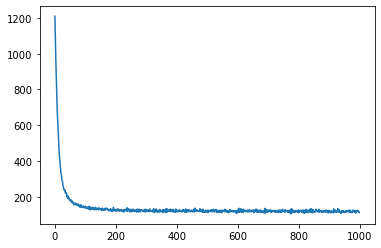

In [11]:
plt.plot(loss_plot)

Check the cosine similarity of Poliwag and Squirtle, two identical pokemon.

In [12]:
#TESTING
context = ['Poliwag','Squirtle']
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector)
print(a)
print(torch.argmax(a[0]).item())
#Print result
print(f'Context: {context}\n')
print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')

tensor([[ -8.1211, -20.2651, -16.4221, -10.1697, -13.0607, -11.0649, -17.4139,
         -10.8680, -19.2964, -13.6906,  -0.5353, -11.1847,  -7.9252, -16.7776,
         -12.5692, -18.4066, -10.3447, -15.8397, -12.2175, -16.3796, -11.8842,
          -0.8839, -13.3404, -15.6293, -11.2635, -13.1165,  -7.5440]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)
10
Context: ['Poliwag', 'Squirtle']

Prediction: Poliwag


In [13]:
print(word_to_ix['Poliwag'])

10


In [14]:
print(word_to_ix['Squirtle'])

21


Get cosine similarity for all Pokemon.

In [15]:
import itertools
from collections import defaultdict

d = defaultdict(lambda: [])

pokemon_list = list(itertools.permutations(vocab, 2))
for pool in pokemon_list:
    input1 = model.get_word_embedding(pool[0])
    input2 = model.get_word_embedding(pool[1])
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    output = cos(input1, input2).item()
    d[pool[0]].append((pool[1],output))

Check which Pokemon Poliwag is most similar to.

In [16]:
d['Poliwag']

[('Bulbasaur', 0.46741974353790283),
 ('Horsea', -0.19772279262542725),
 ('Diglett', 0.019868826493620872),
 ('Machop', -0.09364822506904602),
 ('Jynx', 0.29593735933303833),
 ('Ekans', -0.14527802169322968),
 ('Omanyte', 0.19598719477653503),
 ('Dratini', -0.2777375876903534),
 ('Sandshrew', -0.017771689221262932),
 ('Gastly', 0.05930817499756813),
 ('Meowth', -0.19986580312252045),
 ('Slowpoke', 0.3746568560600281),
 ('Charmander', -0.16343793272972107),
 ('Rattata', 0.34981614351272583),
 ('Cubone', -0.15358136594295502),
 ('Mankey', 0.15166813135147095),
 ('Lapras', -0.24561935663223267),
 ('Tauros', 0.19125878810882568),
 ('Grimer', -0.04380637779831886),
 ('Jigglypuff', -0.1111891120672226),
 ('Squirtle', 0.06919104605913162),
 ('Pidgey', -0.26204830408096313),
 ('Clefairy', 0.07253571599721909),
 ('Abra', 0.2262534499168396),
 ('Zubat', 0.13980484008789062),
 ('Pikachu', 0.04191960394382477)]

Check which Pokemon Squirtle is most similar to.

In [17]:
d['Squirtle']

[('Bulbasaur', -0.17644058167934418),
 ('Horsea', -0.008482929319143295),
 ('Diglett', 0.3172948658466339),
 ('Machop', 0.1876491904258728),
 ('Jynx', -0.04209582135081291),
 ('Ekans', 0.20868359506130219),
 ('Omanyte', 0.19707587361335754),
 ('Dratini', 0.05371731147170067),
 ('Sandshrew', 0.1350208967924118),
 ('Gastly', -0.205365851521492),
 ('Poliwag', 0.06919104605913162),
 ('Meowth', 0.19091461598873138),
 ('Slowpoke', -0.03554027900099754),
 ('Charmander', -0.071806900203228),
 ('Rattata', -0.0350104421377182),
 ('Cubone', -0.27781569957733154),
 ('Mankey', -0.016107924282550812),
 ('Lapras', 0.14693118631839752),
 ('Tauros', -0.25619545578956604),
 ('Grimer', 0.009475565515458584),
 ('Jigglypuff', -0.15009190142154694),
 ('Pidgey', 0.25785040855407715),
 ('Clefairy', 0.026455240324139595),
 ('Abra', 0.07621937990188599),
 ('Zubat', -0.20727607607841492),
 ('Pikachu', 0.05987247824668884)]

Record embeddings in .csv file.

In [18]:
#torch.save(model.state_dict(), 'pokemon2vec_weights.pth')

In [19]:
embed_data = []

for pokemon in vocab:
    pokemon_embedding = np.concatenate(([pokemon], model.get_word_embedding(pokemon).cpu().detach().numpy()[0]))
    embed_data.append(pokemon_embedding)
embed_data

[array(['Bulbasaur', '0.17687559', '0.024490204', '-0.50628775',
        '-1.2525038', '-1.4793936', '1.0133803', '1.1863556', '-1.3092211',
        '1.224058', '-1.0880578', '-1.3456604', '-0.61366725',
        '0.32769594', '-0.16522121', '-0.91608244', '1.53605', '0.7345229',
        '0.8887723', '1.9196557', '0.6975681', '0.15914339', '0.23050259',
        '-1.3241771', '0.8347122', '0.2915816', '-1.0201617',
        '-0.13914987', '2.1263063', '0.67592746', '1.2042753',
        '-0.11000679', '0.995182'], dtype='<U32'),
 array(['Horsea', '0.50160503', '-0.052333716', '-0.72162235',
        '-0.2844305', '0.9227157', '-1.268923', '-1.893838', '1.7991768',
        '0.07110891', '0.27383822', '-0.6757641', '0.26708892',
        '-0.3325172', '1.9583511', '0.51440513', '0.25338376',
        '-1.4846404', '-0.67387795', '1.3754283', '-0.04043962',
        '-0.21647489', '0.15765844', '-1.8538722', '-1.1090361',
        '-0.51688725', '0.94767845', '0.3200832', '-0.53993887',
        '-

In [20]:
columns = ['Pokemon']
for i in range(EMDEDDING_DIM):
    columns.append('feature'+str(i))
df_embed = pd.DataFrame(embed_data, columns = columns)
df_embed

,Pokemon,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31
0,Bulbasaur,0.17687559,0.024490204,-0.50628775,-1.2525038,-1.4793936,1.0133803,1.1863556,-1.3092211,1.224058,...,-1.3241771,0.8347122,0.2915816,-1.0201617,-0.13914987,2.1263063,0.67592746,1.2042753,-0.11000679,0.995182
1,Horsea,0.50160503,-0.052333716,-0.72162235,-0.2844305,0.9227157,-1.268923,-1.893838,1.7991768,0.07110891,...,-1.8538722,-1.1090361,-0.51688725,0.94767845,0.3200832,-0.53993887,-1.2173096,1.3094885,-0.14725831,-0.549346
2,Diglett,1.8617153,0.6258642,-0.37693298,-0.962984,0.4031467,0.96387386,-1.2150754,0.21703443,-1.5315976,...,-0.855032,-1.204082,2.021872,-1.172745,1.0385303,0.75971794,0.5892226,0.21744387,0.83093077,-0.65067315
3,Machop,-1.734448,0.9112116,-0.0103130555,-1.1500183,1.8228387,-0.35708907,0.69031984,1.0048807,-1.3362563,...,1.8215848,-0.9245115,-0.58110285,0.38813654,0.5421947,0.44924128,-0.308982,-0.5190005,0.8954896,0.8528619
4,Jynx,0.16977404,-0.31782755,2.0838876,-0.10405868,-0.441825,0.4825044,-1.4839125,0.65666497,1.0133198,...,0.25001767,-0.5713662,-1.2754053,0.9463739,0.116124585,-1.3456299,0.9362266,1.057473,0.4868618,-1.238626
5,Ekans,0.9169523,0.57527965,0.17755954,-1.0212435,-0.63317186,0.6748327,-0.40157053,-0.6756476,0.48767412,...,0.20240839,-1.1831149,1.4030733,-1.1696807,0.019143026,-2.2963057,-1.3410696,-0.4034059,0.2714479,0.4763996
6,Omanyte,-1.2017866,-1.3865502,0.010524895,0.8308205,-0.98774487,2.2829974,-0.85838646,0.5336561,-0.89318746,...,0.3078906,-0.8083978,1.1069069,-0.044499,0.9760075,0.08651217,1.859705,-1.0822778,0.14737391,0.5174232
7,Dratini,0.9619821,0.8289142,0.44197032,0.1157149,-1.0347346,-1.8266635,-1.5952253,0.391958,-0.63300747,...,-0.044398014,-0.6738184,-1.8889769,-1.4793231,0.22182064,-1.7202965,-0.6081212,0.4508679,-0.35451972,0.52672637
8,Sandshrew,0.59780735,1.0638479,-1.5356622,0.83801603,2.042189,1.102815,1.8964504,-0.026394224,0.4598154,...,0.25026536,0.12917332,0.42590457,1.1426245,1.6240981,0.43540448,1.7825011,2.1881428,-0.087539114,0.88699275
9,Gastly,1.0762061,0.19005162,-0.4748596,-0.6033796,-1.1889092,0.1027327,-1.0556252,0.17379014,-1.482441,...,-1.3821144,-0.08625781,-1.4989439,0.36263296,1.5551361,-1.6186142,-0.20949243,1.4200637,-0.7795878,0.13535424


In [21]:
df_embed.to_csv(r'Data/pokemon_small_embeddings.csv', index=False)